In [1]:
import os
import h2o
import joblib  # Import joblib for saving the model
import mlflow
import mlflow.xgboost
import numpy as np
import optuna
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import xgboost as xgb
from h2o.automl import H2OAutoML
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

/Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.chdir(
    r"C:\Users\omsan\Desktop\Om\Mcgill\MMA 2023\Winter 2 2024\Enterpise ML Part 2\Group Project\Spotify-Music"
)

In [2]:
X_train_transformed, X_test_transformed, y_train, y_test = joblib.load(
    "../../data/processed/train_test_transformed_data.joblib"
)

## Training baseline Models using H20 AutoML

In [9]:
# Start H2O cluster
h2o.init()

# Convert data to H2O format, ensuring target columns are properly converted
# Add target column name to the datasets before conversion
target_column = "target"
X_train_transformed[target_column] = y_train.reset_index(drop=True)
X_test_transformed[target_column] = y_test.reset_index(drop=True)

train = h2o.H2OFrame(X_train_transformed)
test = h2o.H2OFrame(X_test_transformed)

# Ensure the target is treated as a categorical variable
train[target_column] = train[target_column].asfactor()
test[target_column] = test[target_column].asfactor()

# Run AutoML
aml = H2OAutoML(max_models=10, seed=42)
aml.train(
    x=train.columns[:-1], y=target_column, training_frame=train, leaderboard_frame=test
)

# Get the leader model
leader = aml.leader

# Evaluate the leader model
performance = leader.model_performance(test)
print(performance)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 51 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_omsan_2rmq5i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.043 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
10:27:12.358: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.3463799646263551
RMSE: 0.588540537793579
LogLoss: 0.9352500844094357
Null degrees of freedom: 5908
Residual degrees of freedom: 5805
Null deviance: 14242.961586886666
Residual deviance: 11052.78549755071
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actu

c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


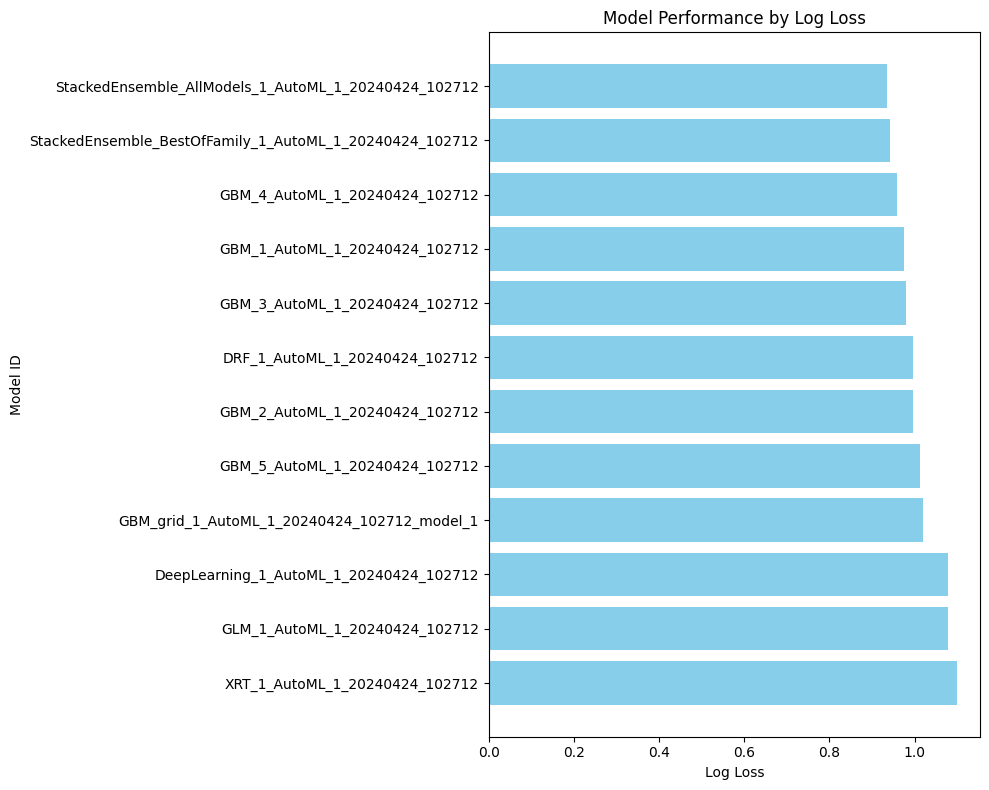

In [18]:
# Create a horizontal bar chart using the logloss
import matplotlib.pyplot as plt

# Assuming 'lb' is the leaderboard from H2OAutoML, but it needs to be defined or passed to this code block
# Convert leaderboard to a Pandas DataFrame
lb_df = aml.leaderboard.as_data_frame()  # Assuming 'aml' is the H2OAutoML object

# Sort the DataFrame by logloss in ascending order to get the best models at the top
lb_df_sorted = lb_df.sort_values(by="logloss", ascending=True)

# Plotting
plt.figure(figsize=(10, 8))  # Adjusted figure size to prevent chopping
plt.barh(lb_df_sorted["model_id"], lb_df_sorted["logloss"], color="skyblue")
plt.xlabel("Log Loss")
plt.ylabel("Model ID")
plt.title("Model Performance by Log Loss")
plt.gca().invert_yaxis()  # Invert y-axis to have the best model on top
plt.tight_layout()  # Adjust layout to make room for the elements

# Save the figure
plt.savefig(
    r"reports\figures\h2o_base_model_results.png", bbox_inches="tight"
)  # Added bbox_inches='tight' to prevent chopping
plt.show()

## Running XGBoost with Optuna

In [5]:
def objective(trial):
    mlflow.set_experiment("XGBoost")
    with mlflow.start_run(nested=True):
        param = {
            "verbosity": 0,
            "objective": "multi:softmax",
            "num_class": len(np.unique(y_train)),
            "eval_metric": "mlogloss",
            "booster": trial.suggest_categorical(
                "booster", ["gbtree", "gblinear", "dart"]
            ),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            param["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical(
                "sample_type", ["uniform", "weighted"]
            )
            param["normalize_type"] = trial.suggest_categorical(
                "normalize_type", ["tree", "forest"]
            )
            param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

        mlflow.log_params(param)

        dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
        dvalid = xgb.DMatrix(X_test_transformed, label=y_test)

        bst = xgb.train(
            param, dtrain, evals=[(dvalid, "validation")], early_stopping_rounds=10
        )
        mlflow.xgboost.log_model(bst, "model")

        preds = bst.predict(dvalid, output_margin=True)
        pred_labels = np.argmax(preds, axis=1)
        accuracy = accuracy_score(y_test, pred_labels)
        mlflow.log_metric("accuracy", accuracy)
        return accuracy

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_trial.params
print("Best trial:", study.best_trial.params)


# Train final model with adjusted labels
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_transformed, y_train)

# Save the model
joblib.dump(final_model, "./models/xgb_optuna_model.joblib")

[I 2024-04-25 23:54:00,653] A new study created in memory with name: no-name-c19ea5b9-8eab-46ce-8dea-d4fffe385de9
2024/04/25 23:54:00 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


/Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-04-25 23:54:02,998] Trial 0 finished with value: 0.4348060344827586 and parameters: {'booster': 'dart', 'lambda': 0.11722522206064385, 'alpha': 0.0032929262754076726, 'max_depth': 1, 'eta': 3.5878272298460552e-06, 'gamma': 2.3937860799182905e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.6836079389591552e-06, 'skip_drop': 0.00893361236160382}. Best is trial 0 with value: 0.4348060344827586.


[0]	validation-mlogloss:1.26180
[1]	validation-mlogloss:1.22198
[2]	validation-mlogloss:1.20413
[3]	validation-mlogloss:1.19552
[4]	validation-mlogloss:1.19096
[5]	validation-mlogloss:1.18838
[6]	validation-mlogloss:1.18682
[7]	validation-mlogloss:1.18578
[8]	validation-mlogloss:1.18506
[9]	validation-mlogloss:1.18453


[I 2024-04-25 23:54:04,369] Trial 1 finished with value: 0.42420977011494254 and parameters: {'booster': 'gblinear', 'lambda': 0.39107770115183965, 'alpha': 0.001214896252328934}. Best is trial 0 with value: 0.4348060344827586.


[0]	validation-mlogloss:1.38577
[1]	validation-mlogloss:1.38526
[2]	validation-mlogloss:1.38474
[3]	validation-mlogloss:1.38423
[4]	validation-mlogloss:1.38372
[5]	validation-mlogloss:1.38321
[6]	validation-mlogloss:1.38270
[7]	validation-mlogloss:1.38218
[8]	validation-mlogloss:1.38168
[9]	validation-mlogloss:1.38117


[I 2024-04-25 23:54:05,810] Trial 2 finished with value: 0.4802442528735632 and parameters: {'booster': 'gbtree', 'lambda': 2.165898082960377e-07, 'alpha': 3.03226544160595e-05, 'max_depth': 8, 'eta': 0.0014627994910830391, 'gamma': 0.0001790167671456205, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.4802442528735632.


[0]	validation-mlogloss:1.18665
[1]	validation-mlogloss:1.13552
[2]	validation-mlogloss:1.11310
[3]	validation-mlogloss:1.10193
[4]	validation-mlogloss:1.09584
[5]	validation-mlogloss:1.09209
[6]	validation-mlogloss:1.08975
[7]	validation-mlogloss:1.08825
[8]	validation-mlogloss:1.08721
[9]	validation-mlogloss:1.08641


[I 2024-04-25 23:54:07,050] Trial 3 finished with value: 0.4953304597701149 and parameters: {'booster': 'gblinear', 'lambda': 6.737252686367166e-05, 'alpha': 3.467560889974954e-05}. Best is trial 3 with value: 0.4953304597701149.


[0]	validation-mlogloss:1.19081
[1]	validation-mlogloss:1.13739
[2]	validation-mlogloss:1.11411
[3]	validation-mlogloss:1.10236
[4]	validation-mlogloss:1.09588
[5]	validation-mlogloss:1.09201
[6]	validation-mlogloss:1.08954
[7]	validation-mlogloss:1.08795
[8]	validation-mlogloss:1.08705
[9]	validation-mlogloss:1.08636


[I 2024-04-25 23:54:08,428] Trial 4 finished with value: 0.4958692528735632 and parameters: {'booster': 'gblinear', 'lambda': 2.9048382759289433e-06, 'alpha': 3.273506906870246e-05}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.38369
[1]	validation-mlogloss:1.38115
[2]	validation-mlogloss:1.37861
[3]	validation-mlogloss:1.37612
[4]	validation-mlogloss:1.37365
[5]	validation-mlogloss:1.37124
[6]	validation-mlogloss:1.36884
[7]	validation-mlogloss:1.36647
[8]	validation-mlogloss:1.36413
[9]	validation-mlogloss:1.36182


[I 2024-04-25 23:54:09,710] Trial 5 finished with value: 0.4375 and parameters: {'booster': 'gbtree', 'lambda': 1.2858279917549426e-07, 'alpha': 3.399170365236547e-07, 'max_depth': 2, 'eta': 0.010131124815320455, 'gamma': 0.04446887237182572, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.38618
[1]	validation-mlogloss:1.38606
[2]	validation-mlogloss:1.38594
[3]	validation-mlogloss:1.38583
[4]	validation-mlogloss:1.38571
[5]	validation-mlogloss:1.38559
[6]	validation-mlogloss:1.38547
[7]	validation-mlogloss:1.38536
[8]	validation-mlogloss:1.38524
[9]	validation-mlogloss:1.38512


[I 2024-04-25 23:54:11,161] Trial 6 finished with value: 0.4401939655172414 and parameters: {'booster': 'dart', 'lambda': 3.662191856787612e-06, 'alpha': 3.1267807759124623e-07, 'max_depth': 2, 'eta': 0.00045497059002452014, 'gamma': 0.6055356983788392, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5675823711662846e-07, 'skip_drop': 8.297934953280115e-07}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-25 23:54:12,479] Trial 7 finished with value: 0.2776580459770115 and parameters: {'booster': 'gbtree', 'lambda': 0.002423673065322425, 'alpha': 0.0007775129675167326, 'max_depth': 6, 'eta': 3.8771868790011724e-08, 'gamma': 0.9793609651505771, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-25 23:54:13,925] Trial 8 finished with value: 0.47467672413793105 and parameters: {'booster': 'gbtree', 'lambda': 5.293253015171406e-05, 'alpha': 1.6391770618341948e-08, 'max_depth': 7, 'eta': 2.5622290867120274e-06, 'gamma': 8.325996644567945e-06, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-25 23:54:15,143] Trial 9 finished with value: 0.21282327586206898 and parameters: {'booster': 'gbtree', 'lambda': 0.5814822581868995, 'alpha': 5.1668213611988834e-06, 'max_depth': 1, 'eta': 1.735939366984609e-08, 'gamma': 0.0001374789523300436, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.30439
[1]	validation-mlogloss:1.26459
[2]	validation-mlogloss:1.24186
[3]	validation-mlogloss:1.22845
[4]	validation-mlogloss:1.22043
[5]	validation-mlogloss:1.21560
[6]	validation-mlogloss:1.21270
[7]	validation-mlogloss:1.21097
[8]	validation-mlogloss:1.20994
[9]	validation-mlogloss:1.20933


[I 2024-04-25 23:54:16,459] Trial 10 finished with value: 0.38739224137931033 and parameters: {'booster': 'gblinear', 'lambda': 2.6182106396409454e-08, 'alpha': 0.44228678890117445}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.19047
[1]	validation-mlogloss:1.13707
[2]	validation-mlogloss:1.11403
[3]	validation-mlogloss:1.10247
[4]	validation-mlogloss:1.09609
[5]	validation-mlogloss:1.09233
[6]	validation-mlogloss:1.08990
[7]	validation-mlogloss:1.08827
[8]	validation-mlogloss:1.08731
[9]	validation-mlogloss:1.08654


[I 2024-04-25 23:54:17,719] Trial 11 finished with value: 0.49461206896551724 and parameters: {'booster': 'gblinear', 'lambda': 0.00014007089872238092, 'alpha': 1.831480021313279e-05}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.29079
[1]	validation-mlogloss:1.25171
[2]	validation-mlogloss:1.23302
[3]	validation-mlogloss:1.22337
[4]	validation-mlogloss:1.21809
[5]	validation-mlogloss:1.21503
[6]	validation-mlogloss:1.21306
[7]	validation-mlogloss:1.21175
[8]	validation-mlogloss:1.21087
[9]	validation-mlogloss:1.21024


[I 2024-04-25 23:54:19,010] Trial 12 finished with value: 0.38739224137931033 and parameters: {'booster': 'gblinear', 'lambda': 5.206509823274179e-06, 'alpha': 0.078780415027688}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.19443
[1]	validation-mlogloss:1.14084
[2]	validation-mlogloss:1.11816
[3]	validation-mlogloss:1.10691
[4]	validation-mlogloss:1.10063
[5]	validation-mlogloss:1.09699
[6]	validation-mlogloss:1.09467
[7]	validation-mlogloss:1.09317
[8]	validation-mlogloss:1.09211
[9]	validation-mlogloss:1.09132


[I 2024-04-25 23:54:20,277] Trial 13 finished with value: 0.49389367816091956 and parameters: {'booster': 'gblinear', 'lambda': 0.0020720005051553013, 'alpha': 1.7782664626168986e-06}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.19251
[1]	validation-mlogloss:1.13922
[2]	validation-mlogloss:1.11613
[3]	validation-mlogloss:1.10448
[4]	validation-mlogloss:1.09776
[5]	validation-mlogloss:1.09372
[6]	validation-mlogloss:1.09126
[7]	validation-mlogloss:1.08949
[8]	validation-mlogloss:1.08825
[9]	validation-mlogloss:1.08742


[I 2024-04-25 23:54:21,583] Trial 14 finished with value: 0.4953304597701149 and parameters: {'booster': 'gblinear', 'lambda': 4.245178378256439e-06, 'alpha': 0.00025864096715863245}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.27317
[1]	validation-mlogloss:1.23463
[2]	validation-mlogloss:1.21711
[3]	validation-mlogloss:1.20771
[4]	validation-mlogloss:1.20247
[5]	validation-mlogloss:1.19941
[6]	validation-mlogloss:1.19747
[7]	validation-mlogloss:1.19616
[8]	validation-mlogloss:1.19524
[9]	validation-mlogloss:1.19454


[I 2024-04-25 23:54:22,792] Trial 15 finished with value: 0.4118175287356322 and parameters: {'booster': 'gblinear', 'lambda': 0.00017614998727083543, 'alpha': 0.02362498284642327}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.19709
[1]	validation-mlogloss:1.14473
[2]	validation-mlogloss:1.12185
[3]	validation-mlogloss:1.11073
[4]	validation-mlogloss:1.10468
[5]	validation-mlogloss:1.10130
[6]	validation-mlogloss:1.09891
[7]	validation-mlogloss:1.09736
[8]	validation-mlogloss:1.09633
[9]	validation-mlogloss:1.09554


[I 2024-04-25 23:54:24,200] Trial 16 finished with value: 0.492816091954023 and parameters: {'booster': 'gblinear', 'lambda': 0.0034384227176113727, 'alpha': 0.00010288700688881013}. Best is trial 4 with value: 0.4958692528735632.


[0]	validation-mlogloss:1.24644
[1]	validation-mlogloss:1.18255
[2]	validation-mlogloss:1.14635
[3]	validation-mlogloss:1.12460
[4]	validation-mlogloss:1.11087
[5]	validation-mlogloss:1.09980
[6]	validation-mlogloss:1.09906
[7]	validation-mlogloss:1.09116
[8]	validation-mlogloss:1.08499
[9]	validation-mlogloss:1.07840


[I 2024-04-25 23:54:25,659] Trial 17 finished with value: 0.5007183908045977 and parameters: {'booster': 'dart', 'lambda': 8.073249657273067e-07, 'alpha': 1.617645174512026e-08, 'max_depth': 4, 'eta': 0.5887675884866383, 'gamma': 1.3389758349976863e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.6686601891758601, 'skip_drop': 0.8123363946608516}. Best is trial 17 with value: 0.5007183908045977.


[0]	validation-mlogloss:1.20341
[1]	validation-mlogloss:1.14573
[2]	validation-mlogloss:1.11725
[3]	validation-mlogloss:1.10295
[4]	validation-mlogloss:1.09265
[5]	validation-mlogloss:1.08443
[6]	validation-mlogloss:1.08005
[7]	validation-mlogloss:1.07980
[8]	validation-mlogloss:1.07559
[9]	validation-mlogloss:1.07527


[I 2024-04-25 23:54:27,067] Trial 18 finished with value: 0.5034123563218391 and parameters: {'booster': 'dart', 'lambda': 8.215025342689576e-07, 'alpha': 1.1747178719864405e-08, 'max_depth': 4, 'eta': 0.8630791528303013, 'gamma': 1.8938364922123527e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.592151186553017, 'skip_drop': 0.9323843943768487}. Best is trial 18 with value: 0.5034123563218391.


[0]	validation-mlogloss:1.20633
[1]	validation-mlogloss:1.14806
[2]	validation-mlogloss:1.11926
[3]	validation-mlogloss:1.10444
[4]	validation-mlogloss:1.09314
[5]	validation-mlogloss:1.08554
[6]	validation-mlogloss:1.08503
[7]	validation-mlogloss:1.07885
[8]	validation-mlogloss:1.07354
[9]	validation-mlogloss:1.07103


[I 2024-04-25 23:54:28,431] Trial 19 finished with value: 0.5026939655172413 and parameters: {'booster': 'dart', 'lambda': 4.191712382495428e-07, 'alpha': 1.2748793713510504e-08, 'max_depth': 4, 'eta': 0.8413163312834738, 'gamma': 1.027944770077138e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.705331734673053, 'skip_drop': 0.8554456949482265}. Best is trial 18 with value: 0.5034123563218391.


[0]	validation-mlogloss:1.19246
[1]	validation-mlogloss:1.13826
[2]	validation-mlogloss:1.11356
[3]	validation-mlogloss:1.09882
[4]	validation-mlogloss:1.08858
[5]	validation-mlogloss:1.08304
[6]	validation-mlogloss:1.07746
[7]	validation-mlogloss:1.07666
[8]	validation-mlogloss:1.07254
[9]	validation-mlogloss:1.06846


[I 2024-04-25 23:54:29,934] Trial 20 finished with value: 0.5053879310344828 and parameters: {'booster': 'dart', 'lambda': 1.2154969309193451e-08, 'alpha': 9.254549246324814e-08, 'max_depth': 4, 'eta': 0.9508721923896443, 'gamma': 7.919354300069438e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2965295228525374, 'skip_drop': 0.9441146461042387}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.19244
[1]	validation-mlogloss:1.13825
[2]	validation-mlogloss:1.11355
[3]	validation-mlogloss:1.09882
[4]	validation-mlogloss:1.08858
[5]	validation-mlogloss:1.08303
[6]	validation-mlogloss:1.08241
[7]	validation-mlogloss:1.07602
[8]	validation-mlogloss:1.07208
[9]	validation-mlogloss:1.06937


[I 2024-04-25 23:54:31,431] Trial 21 finished with value: 0.5039511494252874 and parameters: {'booster': 'dart', 'lambda': 1.2458888449145085e-08, 'alpha': 7.875953562135893e-08, 'max_depth': 4, 'eta': 0.9510046796155557, 'gamma': 4.882212058456285e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.5684715144882868, 'skip_drop': 0.8781324727411336}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.38017
[1]	validation-mlogloss:1.37423
[2]	validation-mlogloss:1.36843
[3]	validation-mlogloss:1.36284
[4]	validation-mlogloss:1.35739
[5]	validation-mlogloss:1.35208
[6]	validation-mlogloss:1.34695
[7]	validation-mlogloss:1.34188
[8]	validation-mlogloss:1.33701
[9]	validation-mlogloss:1.33222


[I 2024-04-25 23:54:32,965] Trial 22 finished with value: 0.47270114942528735 and parameters: {'booster': 'dart', 'lambda': 1.06404054476272e-08, 'alpha': 1.179362744322881e-07, 'max_depth': 4, 'eta': 0.020989823251008427, 'gamma': 5.655876179480495e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.021852474837793442, 'skip_drop': 0.8333135306640639}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.35797
[1]	validation-mlogloss:1.33325
[2]	validation-mlogloss:1.31120
[3]	validation-mlogloss:1.29152
[4]	validation-mlogloss:1.27389
[5]	validation-mlogloss:1.25801
[6]	validation-mlogloss:1.24349
[7]	validation-mlogloss:1.23055
[8]	validation-mlogloss:1.21866
[9]	validation-mlogloss:1.20741


[I 2024-04-25 23:54:34,541] Trial 23 finished with value: 0.49048132183908044 and parameters: {'booster': 'dart', 'lambda': 4.211018261182543e-08, 'alpha': 9.277822137463952e-08, 'max_depth': 5, 'eta': 0.09510139435471879, 'gamma': 5.517989427656169e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.003799224657368442, 'skip_drop': 0.003824837261093536}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.20745
[1]	validation-mlogloss:1.18947
[2]	validation-mlogloss:1.17991
[3]	validation-mlogloss:1.17223
[4]	validation-mlogloss:1.16637
[5]	validation-mlogloss:1.16431
[6]	validation-mlogloss:1.16212
[7]	validation-mlogloss:1.15906
[8]	validation-mlogloss:1.15749
[9]	validation-mlogloss:1.15604


[I 2024-04-25 23:54:35,965] Trial 24 finished with value: 0.45761494252873564 and parameters: {'booster': 'dart', 'lambda': 5.2737881326795e-08, 'alpha': 1.3472627515489327e-06, 'max_depth': 3, 'eta': 0.9074172007707609, 'gamma': 5.50388989809208e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.8882699306032513, 'skip_drop': 0.014371021565254674}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.36786
[1]	validation-mlogloss:1.35099
[2]	validation-mlogloss:1.33535
[3]	validation-mlogloss:1.32109
[4]	validation-mlogloss:1.30754
[5]	validation-mlogloss:1.29493
[6]	validation-mlogloss:1.28322
[7]	validation-mlogloss:1.27239
[8]	validation-mlogloss:1.26213
[9]	validation-mlogloss:1.25264


[I 2024-04-25 23:54:37,409] Trial 25 finished with value: 0.4827586206896552 and parameters: {'booster': 'dart', 'lambda': 7.065200901234776e-07, 'alpha': 7.387039964073993e-08, 'max_depth': 5, 'eta': 0.06119240788515878, 'gamma': 4.56412790573431e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.008261995648827186, 'skip_drop': 0.046749516068409686}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.35482
[1]	validation-mlogloss:1.32799
[2]	validation-mlogloss:1.30469
[3]	validation-mlogloss:1.28451
[4]	validation-mlogloss:1.26722
[5]	validation-mlogloss:1.25146
[6]	validation-mlogloss:1.23751
[7]	validation-mlogloss:1.23114
[8]	validation-mlogloss:1.21965
[9]	validation-mlogloss:1.21603


[I 2024-04-25 23:54:38,859] Trial 26 finished with value: 0.4599497126436782 and parameters: {'booster': 'dart', 'lambda': 1.0418120876554273e-08, 'alpha': 1.0937623970123803e-06, 'max_depth': 3, 'eta': 0.11850225965092429, 'gamma': 1.1785064318133439e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.029951809445846477, 'skip_drop': 0.00016448287040774209}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.38505
[1]	validation-mlogloss:1.38382
[2]	validation-mlogloss:1.38260
[3]	validation-mlogloss:1.38138
[4]	validation-mlogloss:1.38018
[5]	validation-mlogloss:1.37898
[6]	validation-mlogloss:1.37778
[7]	validation-mlogloss:1.37659
[8]	validation-mlogloss:1.37541
[9]	validation-mlogloss:1.37424


[I 2024-04-25 23:54:40,426] Trial 27 finished with value: 0.47683189655172414 and parameters: {'booster': 'dart', 'lambda': 7.87855556258661e-08, 'alpha': 6.512837985931662e-08, 'max_depth': 6, 'eta': 0.003867138796041996, 'gamma': 8.997998259495174e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00012099681164355047, 'skip_drop': 1.1254235315719989e-07}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.38628
[1]	validation-mlogloss:1.38627
[2]	validation-mlogloss:1.38626
[3]	validation-mlogloss:1.38625
[4]	validation-mlogloss:1.38624
[5]	validation-mlogloss:1.38623
[6]	validation-mlogloss:1.38622
[7]	validation-mlogloss:1.38622
[8]	validation-mlogloss:1.38622
[9]	validation-mlogloss:1.38621


[I 2024-04-25 23:54:41,846] Trial 28 finished with value: 0.4561781609195402 and parameters: {'booster': 'dart', 'lambda': 2.1734198644459438e-05, 'alpha': 2.849086062463511e-07, 'max_depth': 3, 'eta': 4.415672606504011e-05, 'gamma': 1.840487254262212e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10930781138951015, 'skip_drop': 0.08801095224714468}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.34484
[1]	validation-mlogloss:1.31110
[2]	validation-mlogloss:1.28127
[3]	validation-mlogloss:1.25693
[4]	validation-mlogloss:1.23529
[5]	validation-mlogloss:1.21649
[6]	validation-mlogloss:1.20020
[7]	validation-mlogloss:1.18526
[8]	validation-mlogloss:1.17205
[9]	validation-mlogloss:1.15989


[I 2024-04-25 23:54:43,413] Trial 29 finished with value: 0.501257183908046 and parameters: {'booster': 'dart', 'lambda': 2.210599034664949e-07, 'alpha': 4.092918710450139e-06, 'max_depth': 6, 'eta': 0.1354735416422931, 'gamma': 0.0027205633376082843, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.314342875535534e-05, 'skip_drop': 0.0006172130572650372}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.38050
[1]	validation-mlogloss:1.37487
[2]	validation-mlogloss:1.36938
[3]	validation-mlogloss:1.36406
[4]	validation-mlogloss:1.35886
[5]	validation-mlogloss:1.35382
[6]	validation-mlogloss:1.34889
[7]	validation-mlogloss:1.34407
[8]	validation-mlogloss:1.33940
[9]	validation-mlogloss:1.33481


[I 2024-04-25 23:54:44,862] Trial 30 finished with value: 0.47270114942528735 and parameters: {'booster': 'dart', 'lambda': 1.0268438175436588e-08, 'alpha': 3.849213688398032e-08, 'max_depth': 4, 'eta': 0.019845157914934027, 'gamma': 2.5252720283352204e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0010128058615112, 'skip_drop': 3.4738541484915082e-06}. Best is trial 20 with value: 0.5053879310344828.


[0]	validation-mlogloss:1.18965
[1]	validation-mlogloss:1.13565
[2]	validation-mlogloss:1.11299
[3]	validation-mlogloss:1.09987
[4]	validation-mlogloss:1.09054
[5]	validation-mlogloss:1.08661
[6]	validation-mlogloss:1.08612
[7]	validation-mlogloss:1.08163
[8]	validation-mlogloss:1.07529
[9]	validation-mlogloss:1.07018


[I 2024-04-25 23:54:46,349] Trial 31 finished with value: 0.5055675287356322 and parameters: {'booster': 'dart', 'lambda': 5.160695111161801e-07, 'alpha': 1.002858208111579e-08, 'max_depth': 4, 'eta': 0.975310335429968, 'gamma': 1.0424696890497521e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.9091328584102538, 'skip_drop': 0.7567320684605795}. Best is trial 31 with value: 0.5055675287356322.


[0]	validation-mlogloss:1.19209
[1]	validation-mlogloss:1.13564
[2]	validation-mlogloss:1.12298
[3]	validation-mlogloss:1.10272
[4]	validation-mlogloss:1.09158
[5]	validation-mlogloss:1.08285
[6]	validation-mlogloss:1.07948
[7]	validation-mlogloss:1.07165
[8]	validation-mlogloss:1.06732
[9]	validation-mlogloss:1.06656


[I 2024-04-25 23:54:47,878] Trial 32 finished with value: 0.5105962643678161 and parameters: {'booster': 'dart', 'lambda': 1.0238716353373425e-06, 'alpha': 1.2798948071748213e-08, 'max_depth': 5, 'eta': 0.9043490285570519, 'gamma': 7.800578949862146e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.15761361992336098, 'skip_drop': 0.16918105502022732}. Best is trial 32 with value: 0.5105962643678161.


[0]	validation-mlogloss:1.33582
[1]	validation-mlogloss:1.29609
[2]	validation-mlogloss:1.27946
[3]	validation-mlogloss:1.24994
[4]	validation-mlogloss:1.22547
[5]	validation-mlogloss:1.20469
[6]	validation-mlogloss:1.18763
[7]	validation-mlogloss:1.17987
[8]	validation-mlogloss:1.17308
[9]	validation-mlogloss:1.16657


[I 2024-04-25 23:54:49,391] Trial 33 finished with value: 0.49658764367816094 and parameters: {'booster': 'dart', 'lambda': 2.6547648582602662e-08, 'alpha': 3.62484522746123e-08, 'max_depth': 5, 'eta': 0.17425701296742432, 'gamma': 9.8522851129474e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08715276131683435, 'skip_drop': 0.108563860745054}. Best is trial 32 with value: 0.5105962643678161.


[0]	validation-mlogloss:1.31597
[1]	validation-mlogloss:1.26534
[2]	validation-mlogloss:1.22949
[3]	validation-mlogloss:1.19828
[4]	validation-mlogloss:1.17470
[5]	validation-mlogloss:1.15634
[6]	validation-mlogloss:1.14175
[7]	validation-mlogloss:1.13489
[8]	validation-mlogloss:1.12937
[9]	validation-mlogloss:1.11980


[I 2024-04-25 23:54:50,940] Trial 34 finished with value: 0.5032327586206896 and parameters: {'booster': 'dart', 'lambda': 1.6665144980868516e-07, 'alpha': 3.281184880870477e-07, 'max_depth': 5, 'eta': 0.24954095024968223, 'gamma': 8.273453359657133e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0847532124682402, 'skip_drop': 0.07005687977000981}. Best is trial 32 with value: 0.5105962643678161.


[0]	validation-mlogloss:1.37873
[1]	validation-mlogloss:1.37147
[2]	validation-mlogloss:1.36794
[3]	validation-mlogloss:1.36109
[4]	validation-mlogloss:1.35444
[5]	validation-mlogloss:1.34801
[6]	validation-mlogloss:1.34591
[7]	validation-mlogloss:1.33974
[8]	validation-mlogloss:1.33380
[9]	validation-mlogloss:1.33314


[I 2024-04-25 23:54:52,348] Trial 35 finished with value: 0.45977011494252873 and parameters: {'booster': 'dart', 'lambda': 1.6941409963193448e-06, 'alpha': 3.226282615398379e-08, 'max_depth': 3, 'eta': 0.027624185185801533, 'gamma': 3.563168590968084e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.15255545389545577, 'skip_drop': 0.1702551326185425}. Best is trial 32 with value: 0.5105962643678161.


[0]	validation-mlogloss:1.31707
[1]	validation-mlogloss:1.26855
[2]	validation-mlogloss:1.24947
[3]	validation-mlogloss:1.21821
[4]	validation-mlogloss:1.19450
[5]	validation-mlogloss:1.17460
[6]	validation-mlogloss:1.16905
[7]	validation-mlogloss:1.15412
[8]	validation-mlogloss:1.14176
[9]	validation-mlogloss:1.14067


[I 2024-04-25 23:54:53,892] Trial 36 finished with value: 0.49191810344827586 and parameters: {'booster': 'dart', 'lambda': 1.870934863088471e-05, 'alpha': 1.5017001290353414e-07, 'max_depth': 4, 'eta': 0.25715695682588624, 'gamma': 1.2808441620219985e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.17077395642658427, 'skip_drop': 0.21797832821088006}. Best is trial 32 with value: 0.5105962643678161.


[0]	validation-mlogloss:1.29242
[1]	validation-mlogloss:1.23239
[2]	validation-mlogloss:1.19113
[3]	validation-mlogloss:1.16068
[4]	validation-mlogloss:1.13526
[5]	validation-mlogloss:1.11806
[6]	validation-mlogloss:1.10347
[7]	validation-mlogloss:1.09249
[8]	validation-mlogloss:1.08459
[9]	validation-mlogloss:1.07633


[I 2024-04-25 23:54:55,363] Trial 37 finished with value: 0.5123922413793104 and parameters: {'booster': 'dart', 'lambda': 2.849683219664438e-07, 'alpha': 7.996105503969115e-07, 'max_depth': 6, 'eta': 0.330832080252439, 'gamma': 4.8629786873169245e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0013108586363249032, 'skip_drop': 0.004151242616079967}. Best is trial 37 with value: 0.5123922413793104.


[0]	validation-mlogloss:1.38479
[1]	validation-mlogloss:1.38331
[2]	validation-mlogloss:1.38183
[3]	validation-mlogloss:1.38036
[4]	validation-mlogloss:1.37891
[5]	validation-mlogloss:1.37746
[6]	validation-mlogloss:1.37601
[7]	validation-mlogloss:1.37458
[8]	validation-mlogloss:1.37315
[9]	validation-mlogloss:1.37173


[I 2024-04-25 23:54:56,867] Trial 38 finished with value: 0.477191091954023 and parameters: {'booster': 'dart', 'lambda': 2.6145937878580605e-07, 'alpha': 1.0555667901835174e-05, 'max_depth': 7, 'eta': 0.004471045326108815, 'gamma': 4.7906308844509455e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0028054631965886423, 'skip_drop': 0.001689455623633963}. Best is trial 37 with value: 0.5123922413793104.


[0]	validation-mlogloss:1.37010
[1]	validation-mlogloss:1.35488
[2]	validation-mlogloss:1.34091
[3]	validation-mlogloss:1.32763
[4]	validation-mlogloss:1.31521
[5]	validation-mlogloss:1.30351
[6]	validation-mlogloss:1.29226
[7]	validation-mlogloss:1.28170
[8]	validation-mlogloss:1.27187
[9]	validation-mlogloss:1.26241


[I 2024-04-25 23:54:58,401] Trial 39 finished with value: 0.4942528735632184 and parameters: {'booster': 'gbtree', 'lambda': 1.2711236720303494e-05, 'alpha': 6.663843264329666e-07, 'max_depth': 7, 'eta': 0.04901317939524979, 'gamma': 5.041720489145657e-08, 'grow_policy': 'depthwise'}. Best is trial 37 with value: 0.5123922413793104.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38628
[5]	validation-mlogloss:1.38628
[6]	validation-mlogloss:1.38628
[7]	validation-mlogloss:1.38628
[8]	validation-mlogloss:1.38628
[9]	validation-mlogloss:1.38627


[I 2024-04-25 23:54:59,981] Trial 40 finished with value: 0.48401580459770116 and parameters: {'booster': 'dart', 'lambda': 9.768546296161439e-08, 'alpha': 6.472918179832909e-07, 'max_depth': 9, 'eta': 5.557570500552025e-06, 'gamma': 3.0642850650606335e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002361335813397567, 'skip_drop': 0.029576000790160536}. Best is trial 37 with value: 0.5123922413793104.


[0]	validation-mlogloss:1.29779
[1]	validation-mlogloss:1.23894
[2]	validation-mlogloss:1.19717
[3]	validation-mlogloss:1.16552
[4]	validation-mlogloss:1.14068
[5]	validation-mlogloss:1.12162
[6]	validation-mlogloss:1.10599
[7]	validation-mlogloss:1.09449
[8]	validation-mlogloss:1.08513
[9]	validation-mlogloss:1.07747


[I 2024-04-25 23:55:01,566] Trial 41 finished with value: 0.5172413793103449 and parameters: {'booster': 'dart', 'lambda': 0.10449465162151098, 'alpha': 3.252620242516501e-08, 'max_depth': 6, 'eta': 0.3102049473791699, 'gamma': 2.699473794925707e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.847175583929433e-05, 'skip_drop': 0.23119637345384977}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.30085
[1]	validation-mlogloss:1.24272
[2]	validation-mlogloss:1.20076
[3]	validation-mlogloss:1.16928
[4]	validation-mlogloss:1.14394
[5]	validation-mlogloss:1.12573
[6]	validation-mlogloss:1.10995
[7]	validation-mlogloss:1.09892
[8]	validation-mlogloss:1.08886
[9]	validation-mlogloss:1.08086


[I 2024-04-25 23:55:03,006] Trial 42 finished with value: 0.5113146551724138 and parameters: {'booster': 'dart', 'lambda': 0.11563719500986262, 'alpha': 2.8020230200782846e-08, 'max_depth': 6, 'eta': 0.29848772748301516, 'gamma': 1.0208630575256654e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.713365262874147e-06, 'skip_drop': 0.21769378203814058}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.31523
[1]	validation-mlogloss:1.26363
[2]	validation-mlogloss:1.22418
[3]	validation-mlogloss:1.19514
[4]	validation-mlogloss:1.16991
[5]	validation-mlogloss:1.14925
[6]	validation-mlogloss:1.13372
[7]	validation-mlogloss:1.11999
[8]	validation-mlogloss:1.10848
[9]	validation-mlogloss:1.09857


[I 2024-04-25 23:55:04,511] Trial 43 finished with value: 0.5091594827586207 and parameters: {'booster': 'dart', 'lambda': 0.08304568345673044, 'alpha': 1.0614377424980278e-08, 'max_depth': 6, 'eta': 0.24264615978480586, 'gamma': 1.2742198339659788e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.484825852180947e-06, 'skip_drop': 0.012835391098307485}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.30905
[1]	validation-mlogloss:1.25459
[2]	validation-mlogloss:1.21417
[3]	validation-mlogloss:1.18399
[4]	validation-mlogloss:1.15859
[5]	validation-mlogloss:1.13980
[6]	validation-mlogloss:1.12519
[7]	validation-mlogloss:1.11220
[8]	validation-mlogloss:1.10155
[9]	validation-mlogloss:1.09240


[I 2024-04-25 23:55:05,861] Trial 44 finished with value: 0.507183908045977 and parameters: {'booster': 'gbtree', 'lambda': 0.1135361447902117, 'alpha': 2.8685052993290452e-08, 'max_depth': 6, 'eta': 0.2661213656844276, 'gamma': 2.2852427995942114e-07, 'grow_policy': 'depthwise'}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.38384
[1]	validation-mlogloss:1.38142
[2]	validation-mlogloss:1.37904
[3]	validation-mlogloss:1.37666
[4]	validation-mlogloss:1.37434
[5]	validation-mlogloss:1.37201
[6]	validation-mlogloss:1.36971
[7]	validation-mlogloss:1.36742
[8]	validation-mlogloss:1.36516
[9]	validation-mlogloss:1.36293


[I 2024-04-25 23:55:07,443] Trial 45 finished with value: 0.48204022988505746 and parameters: {'booster': 'dart', 'lambda': 0.132336812126229, 'alpha': 1.662577807333103e-07, 'max_depth': 7, 'eta': 0.007330734548471261, 'gamma': 2.153706114126816e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.871633264662958e-06, 'skip_drop': 0.00677358229306322}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.38615
[1]	validation-mlogloss:1.38600
[2]	validation-mlogloss:1.38586
[3]	validation-mlogloss:1.38571
[4]	validation-mlogloss:1.38556
[5]	validation-mlogloss:1.38542
[6]	validation-mlogloss:1.38527
[7]	validation-mlogloss:1.38513
[8]	validation-mlogloss:1.38498
[9]	validation-mlogloss:1.38484


[I 2024-04-25 23:55:08,908] Trial 46 finished with value: 0.47611350574712646 and parameters: {'booster': 'dart', 'lambda': 0.02947722678055983, 'alpha': 2.6424249288174054e-08, 'max_depth': 6, 'eta': 0.0004570597907991167, 'gamma': 0.000975452297666628, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.576679094085034e-06, 'skip_drop': 0.0012267982691489055}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.38589
[1]	validation-mlogloss:1.38550
[2]	validation-mlogloss:1.38510
[3]	validation-mlogloss:1.38470
[4]	validation-mlogloss:1.38431
[5]	validation-mlogloss:1.38391
[6]	validation-mlogloss:1.38352
[7]	validation-mlogloss:1.38312
[8]	validation-mlogloss:1.38273
[9]	validation-mlogloss:1.38233


[I 2024-04-25 23:55:10,363] Trial 47 finished with value: 0.48204022988505746 and parameters: {'booster': 'gbtree', 'lambda': 0.013109055912398047, 'alpha': 2.474313599635714e-06, 'max_depth': 8, 'eta': 0.00112731723603551, 'gamma': 3.8951571488789484e-08, 'grow_policy': 'depthwise'}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-25 23:55:11,845] Trial 48 finished with value: 0.48976293103448276 and parameters: {'booster': 'dart', 'lambda': 0.8628129613858995, 'alpha': 2.1367268700028528e-07, 'max_depth': 8, 'eta': 1.549252608465475e-07, 'gamma': 2.1083945040530628e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.331011738360603e-06, 'skip_drop': 0.020073133485465817}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.32004
[1]	validation-mlogloss:1.27112
[2]	validation-mlogloss:1.23398
[3]	validation-mlogloss:1.20499
[4]	validation-mlogloss:1.18106
[5]	validation-mlogloss:1.16186
[6]	validation-mlogloss:1.14690
[7]	validation-mlogloss:1.13389
[8]	validation-mlogloss:1.12303
[9]	validation-mlogloss:1.11409


[I 2024-04-25 23:55:13,344] Trial 49 finished with value: 0.5008979885057471 and parameters: {'booster': 'dart', 'lambda': 0.3395740469548417, 'alpha': 0.005132354550993737, 'max_depth': 5, 'eta': 0.2345558474142858, 'gamma': 0.23193377562410514, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.253401974868497e-07, 'skip_drop': 0.006950123208309724}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.37379
[1]	validation-mlogloss:1.36194
[2]	validation-mlogloss:1.35084
[3]	validation-mlogloss:1.34025
[4]	validation-mlogloss:1.33029
[5]	validation-mlogloss:1.32063
[6]	validation-mlogloss:1.31138
[7]	validation-mlogloss:1.30255
[8]	validation-mlogloss:1.29393
[9]	validation-mlogloss:1.28593


[I 2024-04-25 23:55:14,794] Trial 50 finished with value: 0.48419540229885055 and parameters: {'booster': 'dart', 'lambda': 0.0010184116592130785, 'alpha': 4.916768617136881e-07, 'max_depth': 6, 'eta': 0.039449722587754955, 'gamma': 1.7865489449785745e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.100003283084597e-06, 'skip_drop': 0.1873665164577659}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.30849
[1]	validation-mlogloss:1.25388
[2]	validation-mlogloss:1.21336
[3]	validation-mlogloss:1.18349
[4]	validation-mlogloss:1.15811
[5]	validation-mlogloss:1.13917
[6]	validation-mlogloss:1.12393
[7]	validation-mlogloss:1.11034
[8]	validation-mlogloss:1.09935
[9]	validation-mlogloss:1.09089


[I 2024-04-25 23:55:16,131] Trial 51 finished with value: 0.509698275862069 and parameters: {'booster': 'gbtree', 'lambda': 0.04453998034505935, 'alpha': 2.8138663377754327e-08, 'max_depth': 6, 'eta': 0.2680438245019937, 'gamma': 2.725773428401667e-07, 'grow_policy': 'depthwise'}. Best is trial 41 with value: 0.5172413793103449.


[0]	validation-mlogloss:1.29387
[1]	validation-mlogloss:1.23276
[2]	validation-mlogloss:1.19079
[3]	validation-mlogloss:1.15810
[4]	validation-mlogloss:1.13468
[5]	validation-mlogloss:1.11401
[6]	validation-mlogloss:1.09867
[7]	validation-mlogloss:1.08621
[8]	validation-mlogloss:1.07647
[9]	validation-mlogloss:1.06827


[I 2024-04-25 23:55:17,528] Trial 52 finished with value: 0.5202945402298851 and parameters: {'booster': 'gbtree', 'lambda': 0.039664458434600786, 'alpha': 3.338831794953724e-08, 'max_depth': 7, 'eta': 0.3095967198273853, 'gamma': 2.7185873467825427e-08, 'grow_policy': 'depthwise'}. Best is trial 52 with value: 0.5202945402298851.


[0]	validation-mlogloss:1.27413
[1]	validation-mlogloss:1.20816
[2]	validation-mlogloss:1.16321
[3]	validation-mlogloss:1.13245
[4]	validation-mlogloss:1.10901
[5]	validation-mlogloss:1.09296
[6]	validation-mlogloss:1.07893
[7]	validation-mlogloss:1.06875
[8]	validation-mlogloss:1.06157
[9]	validation-mlogloss:1.05457


[I 2024-04-25 23:55:18,940] Trial 53 finished with value: 0.5174209770114943 and parameters: {'booster': 'gbtree', 'lambda': 0.028738313830669937, 'alpha': 4.1685450112782116e-08, 'max_depth': 7, 'eta': 0.38850817153022316, 'gamma': 2.2031872691196984e-08, 'grow_policy': 'depthwise'}. Best is trial 52 with value: 0.5202945402298851.


[0]	validation-mlogloss:1.36070
[1]	validation-mlogloss:1.33784
[2]	validation-mlogloss:1.31747
[3]	validation-mlogloss:1.29862
[4]	validation-mlogloss:1.28142
[5]	validation-mlogloss:1.26573
[6]	validation-mlogloss:1.25129
[7]	validation-mlogloss:1.23826
[8]	validation-mlogloss:1.22575
[9]	validation-mlogloss:1.21488


[I 2024-04-25 23:55:20,233] Trial 54 finished with value: 0.4958692528735632 and parameters: {'booster': 'gbtree', 'lambda': 0.01371134097736398, 'alpha': 5.069018378385317e-08, 'max_depth': 7, 'eta': 0.07830582174421052, 'gamma': 2.199543797508658e-08, 'grow_policy': 'depthwise'}. Best is trial 52 with value: 0.5202945402298851.


[0]	validation-mlogloss:1.24791
[1]	validation-mlogloss:1.17757
[2]	validation-mlogloss:1.12890
[3]	validation-mlogloss:1.09827
[4]	validation-mlogloss:1.07829
[5]	validation-mlogloss:1.06421
[6]	validation-mlogloss:1.05292
[7]	validation-mlogloss:1.04412
[8]	validation-mlogloss:1.03878
[9]	validation-mlogloss:1.03411


[I 2024-04-25 23:55:21,720] Trial 55 finished with value: 0.5213721264367817 and parameters: {'booster': 'gbtree', 'lambda': 0.19630067390423633, 'alpha': 1.7890188118620715e-08, 'max_depth': 8, 'eta': 0.47963623868688654, 'gamma': 2.456996950592059e-08, 'grow_policy': 'depthwise'}. Best is trial 55 with value: 0.5213721264367817.


[0]	validation-mlogloss:1.26121
[1]	validation-mlogloss:1.18780
[2]	validation-mlogloss:1.14426
[3]	validation-mlogloss:1.11057
[4]	validation-mlogloss:1.08738
[5]	validation-mlogloss:1.07114
[6]	validation-mlogloss:1.06072
[7]	validation-mlogloss:1.04939
[8]	validation-mlogloss:1.04028
[9]	validation-mlogloss:1.03201


[I 2024-04-25 23:55:23,169] Trial 56 finished with value: 0.5246048850574713 and parameters: {'booster': 'gbtree', 'lambda': 0.27305889674121947, 'alpha': 0.0001024905244089162, 'max_depth': 9, 'eta': 0.4098609498789447, 'gamma': 3.022318524811572e-08, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.5246048850574713.


[0]	validation-mlogloss:1.38256
[1]	validation-mlogloss:1.37888
[2]	validation-mlogloss:1.37526
[3]	validation-mlogloss:1.37173
[4]	validation-mlogloss:1.36824
[5]	validation-mlogloss:1.36477
[6]	validation-mlogloss:1.36135
[7]	validation-mlogloss:1.35798
[8]	validation-mlogloss:1.35469
[9]	validation-mlogloss:1.35144


[I 2024-04-25 23:55:24,618] Trial 57 finished with value: 0.48563218390804597 and parameters: {'booster': 'gbtree', 'lambda': 0.008292682278736562, 'alpha': 0.0001517756541768756, 'max_depth': 9, 'eta': 0.01019649406081405, 'gamma': 2.4907831785829082e-08, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.5246048850574713.


[0]	validation-mlogloss:1.25421
[1]	validation-mlogloss:1.18300
[2]	validation-mlogloss:1.13748
[3]	validation-mlogloss:1.10710
[4]	validation-mlogloss:1.08568
[5]	validation-mlogloss:1.06848
[6]	validation-mlogloss:1.05679
[7]	validation-mlogloss:1.04763
[8]	validation-mlogloss:1.04098
[9]	validation-mlogloss:1.03630


[I 2024-04-25 23:55:26,068] Trial 58 finished with value: 0.5242456896551724 and parameters: {'booster': 'gbtree', 'lambda': 0.3701907650279718, 'alpha': 0.0013032208317964658, 'max_depth': 8, 'eta': 0.4520498995796817, 'gamma': 1.014119504968743e-08, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.5246048850574713.


[0]	validation-mlogloss:1.35834
[1]	validation-mlogloss:1.33298
[2]	validation-mlogloss:1.31103
[3]	validation-mlogloss:1.29082
[4]	validation-mlogloss:1.27275
[5]	validation-mlogloss:1.25637
[6]	validation-mlogloss:1.24114
[7]	validation-mlogloss:1.22708
[8]	validation-mlogloss:1.21485
[9]	validation-mlogloss:1.20318


[I 2024-04-25 23:55:27,457] Trial 59 finished with value: 0.5053879310344828 and parameters: {'booster': 'gbtree', 'lambda': 0.4228321262321839, 'alpha': 0.0007080312754817333, 'max_depth': 8, 'eta': 0.08197116606579115, 'gamma': 1.0753641242490278e-08, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.5246048850574713.


[0]	validation-mlogloss:1.24265
[1]	validation-mlogloss:1.17230
[2]	validation-mlogloss:1.12353
[3]	validation-mlogloss:1.09328
[4]	validation-mlogloss:1.07331
[5]	validation-mlogloss:1.06103
[6]	validation-mlogloss:1.04908
[7]	validation-mlogloss:1.04108
[8]	validation-mlogloss:1.03678
[9]	validation-mlogloss:1.03351


[I 2024-04-25 23:55:28,912] Trial 60 finished with value: 0.5264008620689655 and parameters: {'booster': 'gbtree', 'lambda': 0.25882678811740706, 'alpha': 0.003411528632677434, 'max_depth': 8, 'eta': 0.5035270375224292, 'gamma': 2.254466704554211e-08, 'grow_policy': 'depthwise'}. Best is trial 60 with value: 0.5264008620689655.


[0]	validation-mlogloss:1.25922
[1]	validation-mlogloss:1.18921
[2]	validation-mlogloss:1.14219
[3]	validation-mlogloss:1.11068
[4]	validation-mlogloss:1.09007
[5]	validation-mlogloss:1.07398
[6]	validation-mlogloss:1.05996
[7]	validation-mlogloss:1.04997
[8]	validation-mlogloss:1.04273
[9]	validation-mlogloss:1.03801


[I 2024-04-25 23:55:30,305] Trial 61 finished with value: 0.5276580459770115 and parameters: {'booster': 'gbtree', 'lambda': 0.2460640671299142, 'alpha': 0.005998154646019949, 'max_depth': 8, 'eta': 0.430412157627629, 'gamma': 1.7524543865751965e-08, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 0.5276580459770115.


[0]	validation-mlogloss:1.25036
[1]	validation-mlogloss:1.18038
[2]	validation-mlogloss:1.13099
[3]	validation-mlogloss:1.09980
[4]	validation-mlogloss:1.08083
[5]	validation-mlogloss:1.06573
[6]	validation-mlogloss:1.05456
[7]	validation-mlogloss:1.04545
[8]	validation-mlogloss:1.04045
[9]	validation-mlogloss:1.03504


[I 2024-04-25 23:55:31,705] Trial 62 finished with value: 0.5276580459770115 and parameters: {'booster': 'gbtree', 'lambda': 0.22203939257730834, 'alpha': 0.0053719642073959085, 'max_depth': 8, 'eta': 0.46927072622187177, 'gamma': 2.5568106127003407e-08, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 0.5276580459770115.


[0]	validation-mlogloss:1.25210
[1]	validation-mlogloss:1.18150
[2]	validation-mlogloss:1.13386
[3]	validation-mlogloss:1.10363
[4]	validation-mlogloss:1.08127
[5]	validation-mlogloss:1.06566
[6]	validation-mlogloss:1.05567
[7]	validation-mlogloss:1.04552
[8]	validation-mlogloss:1.03884
[9]	validation-mlogloss:1.03430


[I 2024-04-25 23:55:33,087] Trial 63 finished with value: 0.5237068965517241 and parameters: {'booster': 'gbtree', 'lambda': 0.2824724583505352, 'alpha': 0.011872587820818768, 'max_depth': 8, 'eta': 0.4613763512414965, 'gamma': 1.7233566147779735e-08, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 0.5276580459770115.


[0]	validation-mlogloss:1.24153
[1]	validation-mlogloss:1.16831
[2]	validation-mlogloss:1.12435
[3]	validation-mlogloss:1.09323
[4]	validation-mlogloss:1.07373
[5]	validation-mlogloss:1.05817
[6]	validation-mlogloss:1.04762
[7]	validation-mlogloss:1.03845
[8]	validation-mlogloss:1.03307
[9]	validation-mlogloss:1.02845


[I 2024-04-25 23:55:34,622] Trial 64 finished with value: 0.5326867816091954 and parameters: {'booster': 'gbtree', 'lambda': 0.23903343842281297, 'alpha': 0.005059064373610345, 'max_depth': 9, 'eta': 0.4970780543652274, 'gamma': 1.1083178652926233e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.34988
[1]	validation-mlogloss:1.31835
[2]	validation-mlogloss:1.29145
[3]	validation-mlogloss:1.26696
[4]	validation-mlogloss:1.24600
[5]	validation-mlogloss:1.22646
[6]	validation-mlogloss:1.21000
[7]	validation-mlogloss:1.19459
[8]	validation-mlogloss:1.18032
[9]	validation-mlogloss:1.16787


[I 2024-04-25 23:55:36,142] Trial 65 finished with value: 0.5088002873563219 and parameters: {'booster': 'gbtree', 'lambda': 0.8920273502705768, 'alpha': 0.0063980203045088365, 'max_depth': 9, 'eta': 0.10523752365701107, 'gamma': 1.5908663590244512e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.23464
[1]	validation-mlogloss:1.16334
[2]	validation-mlogloss:1.11816
[3]	validation-mlogloss:1.09100
[4]	validation-mlogloss:1.06932
[5]	validation-mlogloss:1.05566
[6]	validation-mlogloss:1.04812
[7]	validation-mlogloss:1.04075
[8]	validation-mlogloss:1.03427
[9]	validation-mlogloss:1.03044


[I 2024-04-25 23:55:37,572] Trial 66 finished with value: 0.5226293103448276 and parameters: {'booster': 'gbtree', 'lambda': 0.23203459814540056, 'alpha': 0.020957767228352155, 'max_depth': 9, 'eta': 0.5298997271141223, 'gamma': 1.1322486979196995e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.34412
[1]	validation-mlogloss:1.30852
[2]	validation-mlogloss:1.27801
[3]	validation-mlogloss:1.25186
[4]	validation-mlogloss:1.22946
[5]	validation-mlogloss:1.20870
[6]	validation-mlogloss:1.19066
[7]	validation-mlogloss:1.17528
[8]	validation-mlogloss:1.16114
[9]	validation-mlogloss:1.14780


[I 2024-04-25 23:55:39,070] Trial 67 finished with value: 0.5118534482758621 and parameters: {'booster': 'gbtree', 'lambda': 0.49983268654629676, 'alpha': 0.0015444503322063683, 'max_depth': 9, 'eta': 0.12225366921307823, 'gamma': 5.1954385982733565e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.37936
[1]	validation-mlogloss:1.37262
[2]	validation-mlogloss:1.36608
[3]	validation-mlogloss:1.35972
[4]	validation-mlogloss:1.35348
[5]	validation-mlogloss:1.34743
[6]	validation-mlogloss:1.34159
[7]	validation-mlogloss:1.33589
[8]	validation-mlogloss:1.33033
[9]	validation-mlogloss:1.32498


[I 2024-04-25 23:55:40,461] Trial 68 finished with value: 0.4956896551724138 and parameters: {'booster': 'gbtree', 'lambda': 0.24787857490687684, 'alpha': 0.017381249021330668, 'max_depth': 8, 'eta': 0.01976552538125937, 'gamma': 1.013625122539763e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.38628
[1]	validation-mlogloss:1.38627
[2]	validation-mlogloss:1.38626
[3]	validation-mlogloss:1.38624
[4]	validation-mlogloss:1.38623
[5]	validation-mlogloss:1.38622
[6]	validation-mlogloss:1.38621
[7]	validation-mlogloss:1.38619
[8]	validation-mlogloss:1.38618
[9]	validation-mlogloss:1.38617


[I 2024-04-25 23:55:41,903] Trial 69 finished with value: 0.47826867816091956 and parameters: {'booster': 'gbtree', 'lambda': 0.9731225603192978, 'alpha': 0.10721578119811413, 'max_depth': 8, 'eta': 3.6242552219524803e-05, 'gamma': 0.007084030765792053, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.36991
[1]	validation-mlogloss:1.35467
[2]	validation-mlogloss:1.34025
[3]	validation-mlogloss:1.32664
[4]	validation-mlogloss:1.31413
[5]	validation-mlogloss:1.30234
[6]	validation-mlogloss:1.29101
[7]	validation-mlogloss:1.28040
[8]	validation-mlogloss:1.27051
[9]	validation-mlogloss:1.26076


[I 2024-04-25 23:55:43,287] Trial 70 finished with value: 0.49982040229885055 and parameters: {'booster': 'gbtree', 'lambda': 0.049565268859035415, 'alpha': 0.0019460376549991954, 'max_depth': 9, 'eta': 0.045201207788872, 'gamma': 7.004570915351214e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.21081
[1]	validation-mlogloss:1.13407
[2]	validation-mlogloss:1.09387
[3]	validation-mlogloss:1.07215
[4]	validation-mlogloss:1.05591
[5]	validation-mlogloss:1.04865
[6]	validation-mlogloss:1.03840
[7]	validation-mlogloss:1.03674
[8]	validation-mlogloss:1.03351
[9]	validation-mlogloss:1.03017


[I 2024-04-25 23:55:44,839] Trial 71 finished with value: 0.5226293103448276 and parameters: {'booster': 'gbtree', 'lambda': 0.20431539103780189, 'alpha': 0.021753646281148103, 'max_depth': 9, 'eta': 0.6603245478638597, 'gamma': 1.6675582790512307e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.22372
[1]	validation-mlogloss:1.15241
[2]	validation-mlogloss:1.11280
[3]	validation-mlogloss:1.08667
[4]	validation-mlogloss:1.06796
[5]	validation-mlogloss:1.05433
[6]	validation-mlogloss:1.04736
[7]	validation-mlogloss:1.04113
[8]	validation-mlogloss:1.03728
[9]	validation-mlogloss:1.03601


[I 2024-04-25 23:55:46,269] Trial 72 finished with value: 0.5202945402298851 and parameters: {'booster': 'gbtree', 'lambda': 0.3228951187678005, 'alpha': 0.01117294997208475, 'max_depth': 8, 'eta': 0.5970796657202582, 'gamma': 1.043145535975011e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.34314
[1]	validation-mlogloss:1.30660
[2]	validation-mlogloss:1.27623
[3]	validation-mlogloss:1.24953
[4]	validation-mlogloss:1.22591
[5]	validation-mlogloss:1.20641
[6]	validation-mlogloss:1.18840
[7]	validation-mlogloss:1.17313
[8]	validation-mlogloss:1.15879
[9]	validation-mlogloss:1.14550


[I 2024-04-25 23:55:47,735] Trial 73 finished with value: 0.5138290229885057 and parameters: {'booster': 'gbtree', 'lambda': 0.4651986970250477, 'alpha': 0.08829076776074621, 'max_depth': 9, 'eta': 0.12535920763876127, 'gamma': 3.830944890708391e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.22665
[1]	validation-mlogloss:1.15516
[2]	validation-mlogloss:1.11353
[3]	validation-mlogloss:1.08845
[4]	validation-mlogloss:1.07159
[5]	validation-mlogloss:1.05672
[6]	validation-mlogloss:1.04769
[7]	validation-mlogloss:1.04127
[8]	validation-mlogloss:1.03933
[9]	validation-mlogloss:1.03709


[I 2024-04-25 23:55:49,180] Trial 74 finished with value: 0.5188577586206896 and parameters: {'booster': 'gbtree', 'lambda': 0.07780787301142895, 'alpha': 0.0005534805338612799, 'max_depth': 9, 'eta': 0.5678395912470672, 'gamma': 1.7924015138062996e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.16902
[1]	validation-mlogloss:1.11040
[2]	validation-mlogloss:1.08790
[3]	validation-mlogloss:1.07566
[4]	validation-mlogloss:1.06758
[5]	validation-mlogloss:1.06544
[6]	validation-mlogloss:1.06509
[7]	validation-mlogloss:1.06566
[8]	validation-mlogloss:1.06721
[9]	validation-mlogloss:1.06642


[I 2024-04-25 23:55:50,658] Trial 75 finished with value: 0.5190373563218391 and parameters: {'booster': 'gbtree', 'lambda': 0.1880950845907102, 'alpha': 0.043550336431691754, 'max_depth': 8, 'eta': 0.989028192652849, 'gamma': 7.067930650077089e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.33247
[1]	validation-mlogloss:1.28957
[2]	validation-mlogloss:1.25370
[3]	validation-mlogloss:1.22543
[4]	validation-mlogloss:1.20122
[5]	validation-mlogloss:1.18110
[6]	validation-mlogloss:1.16306
[7]	validation-mlogloss:1.14745
[8]	validation-mlogloss:1.13274
[9]	validation-mlogloss:1.12022


[I 2024-04-25 23:55:52,075] Trial 76 finished with value: 0.5149066091954023 and parameters: {'booster': 'gbtree', 'lambda': 0.6069766576117182, 'alpha': 0.0029424623004531874, 'max_depth': 8, 'eta': 0.1622832172299718, 'gamma': 2.0945052697580864e-05, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.24795
[1]	validation-mlogloss:1.17523
[2]	validation-mlogloss:1.12954
[3]	validation-mlogloss:1.09586
[4]	validation-mlogloss:1.07354
[5]	validation-mlogloss:1.05879
[6]	validation-mlogloss:1.04537
[7]	validation-mlogloss:1.03662
[8]	validation-mlogloss:1.03161
[9]	validation-mlogloss:1.02799


[I 2024-04-25 23:55:53,602] Trial 77 finished with value: 0.5301724137931034 and parameters: {'booster': 'gbtree', 'lambda': 0.00033773804265994326, 'alpha': 0.2053611542993548, 'max_depth': 9, 'eta': 0.4682097482615926, 'gamma': 3.992522940251364e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.30647
[1]	validation-mlogloss:1.26505
[2]	validation-mlogloss:1.24186
[3]	validation-mlogloss:1.22836
[4]	validation-mlogloss:1.22033
[5]	validation-mlogloss:1.21553
[6]	validation-mlogloss:1.21265
[7]	validation-mlogloss:1.21094
[8]	validation-mlogloss:1.20992
[9]	validation-mlogloss:1.20932


[I 2024-04-25 23:55:54,908] Trial 78 finished with value: 0.38739224137931033 and parameters: {'booster': 'gblinear', 'lambda': 0.0002885235413536757, 'alpha': 0.5730649393627819}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.36335
[1]	validation-mlogloss:1.34252
[2]	validation-mlogloss:1.32381
[3]	validation-mlogloss:1.30668
[4]	validation-mlogloss:1.29038
[5]	validation-mlogloss:1.27553
[6]	validation-mlogloss:1.26165
[7]	validation-mlogloss:1.24888
[8]	validation-mlogloss:1.23728
[9]	validation-mlogloss:1.22635


[I 2024-04-25 23:55:56,482] Trial 79 finished with value: 0.5055675287356322 and parameters: {'booster': 'gbtree', 'lambda': 0.06833090030669825, 'alpha': 0.0004341557130435475, 'max_depth': 8, 'eta': 0.06608523920042587, 'gamma': 4.3820466419931514e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.24533
[1]	validation-mlogloss:1.17002
[2]	validation-mlogloss:1.12688
[3]	validation-mlogloss:1.09696
[4]	validation-mlogloss:1.07814
[5]	validation-mlogloss:1.05967
[6]	validation-mlogloss:1.04824
[7]	validation-mlogloss:1.04069
[8]	validation-mlogloss:1.03705
[9]	validation-mlogloss:1.03146


[I 2024-04-25 23:55:58,284] Trial 80 finished with value: 0.5251436781609196 and parameters: {'booster': 'gbtree', 'lambda': 0.007665220405151649, 'alpha': 0.26762742492524166, 'max_depth': 9, 'eta': 0.48486260445326523, 'gamma': 3.457981352404938e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.24845
[1]	validation-mlogloss:1.17477
[2]	validation-mlogloss:1.12758
[3]	validation-mlogloss:1.09564
[4]	validation-mlogloss:1.07275
[5]	validation-mlogloss:1.05867
[6]	validation-mlogloss:1.04538
[7]	validation-mlogloss:1.03855
[8]	validation-mlogloss:1.03279
[9]	validation-mlogloss:1.02827


[I 2024-04-25 23:55:59,791] Trial 81 finished with value: 0.5237068965517241 and parameters: {'booster': 'gbtree', 'lambda': 0.0008297194149391364, 'alpha': 0.3014084672979704, 'max_depth': 9, 'eta': 0.4727120720610238, 'gamma': 3.072186081472009e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32723
[1]	validation-mlogloss:1.28140
[2]	validation-mlogloss:1.24324
[3]	validation-mlogloss:1.21267
[4]	validation-mlogloss:1.18680
[5]	validation-mlogloss:1.16535
[6]	validation-mlogloss:1.14617
[7]	validation-mlogloss:1.13174
[8]	validation-mlogloss:1.11735
[9]	validation-mlogloss:1.10317


[I 2024-04-25 23:56:01,359] Trial 82 finished with value: 0.5260416666666666 and parameters: {'booster': 'gbtree', 'lambda': 0.0057052601693886205, 'alpha': 0.1843762220267606, 'max_depth': 9, 'eta': 0.1728883944044427, 'gamma': 1.005195697640487e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32966
[1]	validation-mlogloss:1.28549
[2]	validation-mlogloss:1.24902
[3]	validation-mlogloss:1.21996
[4]	validation-mlogloss:1.19507
[5]	validation-mlogloss:1.17373
[6]	validation-mlogloss:1.15594
[7]	validation-mlogloss:1.13979
[8]	validation-mlogloss:1.12467
[9]	validation-mlogloss:1.11162


[I 2024-04-25 23:56:02,792] Trial 83 finished with value: 0.5167025862068966 and parameters: {'booster': 'gbtree', 'lambda': 0.004456930492580005, 'alpha': 0.051655376489686176, 'max_depth': 9, 'eta': 0.16444004312872057, 'gamma': 9.251901738635664e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32329
[1]	validation-mlogloss:1.27555
[2]	validation-mlogloss:1.23672
[3]	validation-mlogloss:1.20523
[4]	validation-mlogloss:1.17938
[5]	validation-mlogloss:1.15735
[6]	validation-mlogloss:1.13952
[7]	validation-mlogloss:1.12371
[8]	validation-mlogloss:1.10800
[9]	validation-mlogloss:1.09409


[I 2024-04-25 23:56:04,378] Trial 84 finished with value: 0.5233477011494253 and parameters: {'booster': 'gbtree', 'lambda': 0.022058278278809934, 'alpha': 0.3329687846918241, 'max_depth': 9, 'eta': 0.18805237456774065, 'gamma': 4.241693773645496e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.37589
[1]	validation-mlogloss:1.36604
[2]	validation-mlogloss:1.35650
[3]	validation-mlogloss:1.34741
[4]	validation-mlogloss:1.33849
[5]	validation-mlogloss:1.33020
[6]	validation-mlogloss:1.32213
[7]	validation-mlogloss:1.31434
[8]	validation-mlogloss:1.30673
[9]	validation-mlogloss:1.29936


[I 2024-04-25 23:56:05,809] Trial 85 finished with value: 0.4956896551724138 and parameters: {'booster': 'gbtree', 'lambda': 8.723555655614351e-05, 'alpha': 0.1981733050068945, 'max_depth': 9, 'eta': 0.02868881741042539, 'gamma': 1.1427078433293894e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.26884
[1]	validation-mlogloss:1.21440
[2]	validation-mlogloss:1.18553
[3]	validation-mlogloss:1.16986
[4]	validation-mlogloss:1.15970
[5]	validation-mlogloss:1.15333
[6]	validation-mlogloss:1.14742
[7]	validation-mlogloss:1.14234
[8]	validation-mlogloss:1.13783
[9]	validation-mlogloss:1.13388


[I 2024-04-25 23:56:07,094] Trial 86 finished with value: 0.4694683908045977 and parameters: {'booster': 'gbtree', 'lambda': 0.0006985299556528219, 'alpha': 4.122716411659283e-05, 'max_depth': 1, 'eta': 0.6601334811879886, 'gamma': 6.023431478899724e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.18302
[1]	validation-mlogloss:1.12479
[2]	validation-mlogloss:1.09754
[3]	validation-mlogloss:1.08147
[4]	validation-mlogloss:1.07474
[5]	validation-mlogloss:1.06798
[6]	validation-mlogloss:1.07156
[7]	validation-mlogloss:1.07141
[8]	validation-mlogloss:1.07447
[9]	validation-mlogloss:1.08044


[I 2024-04-25 23:56:08,581] Trial 87 finished with value: 0.5061063218390804 and parameters: {'booster': 'gbtree', 'lambda': 4.382539349784649e-05, 'alpha': 0.004113895299353643, 'max_depth': 9, 'eta': 0.8999384512798922, 'gamma': 0.00022617719709813205, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.20250
[1]	validation-mlogloss:1.15147
[2]	validation-mlogloss:1.12896
[3]	validation-mlogloss:1.11724
[4]	validation-mlogloss:1.11108
[5]	validation-mlogloss:1.10742
[6]	validation-mlogloss:1.10519
[7]	validation-mlogloss:1.10367
[8]	validation-mlogloss:1.10258
[9]	validation-mlogloss:1.10179


[I 2024-04-25 23:56:09,923] Trial 88 finished with value: 0.4894037356321839 and parameters: {'booster': 'gblinear', 'lambda': 0.0015749130225286088, 'alpha': 0.0011573232519027851}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.35639
[1]	validation-mlogloss:1.32996
[2]	validation-mlogloss:1.30687
[3]	validation-mlogloss:1.28573
[4]	validation-mlogloss:1.26722
[5]	validation-mlogloss:1.25003
[6]	validation-mlogloss:1.23495
[7]	validation-mlogloss:1.22130
[8]	validation-mlogloss:1.20809
[9]	validation-mlogloss:1.19671


[I 2024-04-25 23:56:11,330] Trial 89 finished with value: 0.5037715517241379 and parameters: {'booster': 'gbtree', 'lambda': 0.007868528196728411, 'alpha': 0.7308526624059297, 'max_depth': 8, 'eta': 0.08802309559860362, 'gamma': 1.3867369293746016e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.26831
[1]	validation-mlogloss:1.20067
[2]	validation-mlogloss:1.15466
[3]	validation-mlogloss:1.12221
[4]	validation-mlogloss:1.09589
[5]	validation-mlogloss:1.07732
[6]	validation-mlogloss:1.06260
[7]	validation-mlogloss:1.05249
[8]	validation-mlogloss:1.04181
[9]	validation-mlogloss:1.03432


[I 2024-04-25 23:56:12,825] Trial 90 finished with value: 0.5290948275862069 and parameters: {'booster': 'gbtree', 'lambda': 0.0003742843619938232, 'alpha': 0.15741038433174812, 'max_depth': 9, 'eta': 0.3797522139738168, 'gamma': 9.006606989322385e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.26680
[1]	validation-mlogloss:1.19648
[2]	validation-mlogloss:1.15494
[3]	validation-mlogloss:1.12126
[4]	validation-mlogloss:1.09608
[5]	validation-mlogloss:1.08069
[6]	validation-mlogloss:1.06646
[7]	validation-mlogloss:1.05469
[8]	validation-mlogloss:1.04658
[9]	validation-mlogloss:1.03943


[I 2024-04-25 23:56:14,349] Trial 91 finished with value: 0.5226293103448276 and parameters: {'booster': 'gbtree', 'lambda': 0.15086004637224804, 'alpha': 0.1610313767274497, 'max_depth': 9, 'eta': 0.39106623484918135, 'gamma': 9.490525749184032e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32487
[1]	validation-mlogloss:1.27834
[2]	validation-mlogloss:1.24043
[3]	validation-mlogloss:1.20991
[4]	validation-mlogloss:1.18401
[5]	validation-mlogloss:1.16275
[6]	validation-mlogloss:1.14400
[7]	validation-mlogloss:1.12844
[8]	validation-mlogloss:1.11385
[9]	validation-mlogloss:1.09968


[I 2024-04-25 23:56:15,792] Trial 92 finished with value: 0.5201149425287356 and parameters: {'booster': 'gbtree', 'lambda': 0.0003267464151754158, 'alpha': 0.0077880603874663735, 'max_depth': 9, 'eta': 0.17999869821807338, 'gamma': 3.361203789010331e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.27336
[1]	validation-mlogloss:1.20718
[2]	validation-mlogloss:1.16064
[3]	validation-mlogloss:1.12927
[4]	validation-mlogloss:1.10534
[5]	validation-mlogloss:1.08759
[6]	validation-mlogloss:1.07331
[7]	validation-mlogloss:1.06198
[8]	validation-mlogloss:1.05122
[9]	validation-mlogloss:1.04444


[I 2024-04-25 23:56:17,263] Trial 93 finished with value: 0.5226293103448276 and parameters: {'booster': 'gbtree', 'lambda': 0.00035540795023306234, 'alpha': 0.04202742817017966, 'max_depth': 8, 'eta': 0.3699279039237091, 'gamma': 4.1397159669969396e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32441
[1]	validation-mlogloss:1.27730
[2]	validation-mlogloss:1.23918
[3]	validation-mlogloss:1.20704
[4]	validation-mlogloss:1.18231
[5]	validation-mlogloss:1.16142
[6]	validation-mlogloss:1.14249
[7]	validation-mlogloss:1.12702
[8]	validation-mlogloss:1.11175
[9]	validation-mlogloss:1.09991


[I 2024-04-25 23:56:18,734] Trial 94 finished with value: 0.5226293103448276 and parameters: {'booster': 'gbtree', 'lambda': 0.000149980673962577, 'alpha': 0.8718352728202067, 'max_depth': 9, 'eta': 0.18741338423570675, 'gamma': 1.5834407389128807e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.17428
[1]	validation-mlogloss:1.11436
[2]	validation-mlogloss:1.09073
[3]	validation-mlogloss:1.07662
[4]	validation-mlogloss:1.07538
[5]	validation-mlogloss:1.07314
[6]	validation-mlogloss:1.07384
[7]	validation-mlogloss:1.07338
[8]	validation-mlogloss:1.07439
[9]	validation-mlogloss:1.07295


[I 2024-04-25 23:56:20,240] Trial 95 finished with value: 0.5100574712643678 and parameters: {'booster': 'gbtree', 'lambda': 0.0042828104630614735, 'alpha': 0.002686407194918186, 'max_depth': 8, 'eta': 0.9547159286404238, 'gamma': 5.827064988911391e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.26072
[1]	validation-mlogloss:1.18950
[2]	validation-mlogloss:1.14553
[3]	validation-mlogloss:1.11099
[4]	validation-mlogloss:1.08834
[5]	validation-mlogloss:1.07164
[6]	validation-mlogloss:1.05930
[7]	validation-mlogloss:1.04826
[8]	validation-mlogloss:1.04222
[9]	validation-mlogloss:1.03747


[I 2024-04-25 23:56:21,714] Trial 96 finished with value: 0.5244252873563219 and parameters: {'booster': 'gbtree', 'lambda': 0.0013132094137375996, 'alpha': 0.12288354673591288, 'max_depth': 9, 'eta': 0.4110299591985518, 'gamma': 3.0028429104639635e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-25 23:56:23,326] Trial 97 finished with value: 0.4608477011494253 and parameters: {'booster': 'gbtree', 'lambda': 0.0005660781653717244, 'alpha': 0.17092886510661406, 'max_depth': 9, 'eta': 6.606543807295743e-08, 'gamma': 3.3058755941436605e-08, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.36404
[1]	validation-mlogloss:1.34377
[2]	validation-mlogloss:1.32499
[3]	validation-mlogloss:1.30813
[4]	validation-mlogloss:1.29206
[5]	validation-mlogloss:1.27706
[6]	validation-mlogloss:1.26338
[7]	validation-mlogloss:1.25057
[8]	validation-mlogloss:1.23835
[9]	validation-mlogloss:1.22688


[I 2024-04-25 23:56:24,825] Trial 98 finished with value: 0.5062859195402298 and parameters: {'booster': 'gbtree', 'lambda': 0.0015599275019415422, 'alpha': 0.26819679636483834, 'max_depth': 9, 'eta': 0.0627848378681234, 'gamma': 1.7680868234903945e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


[0]	validation-mlogloss:1.32318
[1]	validation-mlogloss:1.27893
[2]	validation-mlogloss:1.24586
[3]	validation-mlogloss:1.22063
[4]	validation-mlogloss:1.20100
[5]	validation-mlogloss:1.18589
[6]	validation-mlogloss:1.17445
[7]	validation-mlogloss:1.16460
[8]	validation-mlogloss:1.15598
[9]	validation-mlogloss:1.14969


[I 2024-04-25 23:56:26,156] Trial 99 finished with value: 0.46551724137931033 and parameters: {'booster': 'gbtree', 'lambda': 0.0018703030446659925, 'alpha': 0.06021333412421024, 'max_depth': 2, 'eta': 0.2675606666543273, 'gamma': 3.275853103909111e-07, 'grow_policy': 'depthwise'}. Best is trial 64 with value: 0.5326867816091954.


Best trial: {'booster': 'gbtree', 'lambda': 0.23903343842281297, 'alpha': 0.005059064373610345, 'max_depth': 9, 'eta': 0.4970780543652274, 'gamma': 1.1083178652926233e-08, 'grow_policy': 'depthwise'}


FileNotFoundError: [Errno 2] No such file or directory: './models/xgb_optuna_model.joblib'

## PyTorch Lightning Model

In [29]:
# # Load your data
# X_train_transformed, X_test_transformed, y_train, y_test = joblib.load("./data/processed/train_test_transformed_data.joblib")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_test_transformed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.long)
# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


class ClassificationModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        num_classes,
        hidden_size,
        num_hidden_layers,
        dropout_rate,
        activation,
        lr,
    ):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Linear(input_size, hidden_size), get_activation_fn(activation)()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(get_activation_fn(activation)())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


def get_activation_fn(activation):
    if activation == "relu":
        return nn.ReLU
    elif activation == "leaky_relu":
        return nn.LeakyReLU
    elif activation == "elu":
        return nn.ELU
    else:
        raise ValueError(f"Invalid activation function: {activation}")


def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=16)
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "elu"])

    model = ClassificationModel(
        input_size=X_train_transformed.shape[1],
        num_classes=len(np.unique(y_train)),
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        dropout_rate=dropout_rate,
        activation=activation,
        lr=lr,
    )

    early_stop_callback = EarlyStopping(
        monitor="val_loss", patience=5, verbose=True, mode="min"
    )
    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[early_stop_callback],
        accelerator="cuda" if torch.cuda.is_available() else "auto",
    )

    trainer.fit(model, train_loader, val_loader)

    return trainer.callback_metrics["val_loss"].item()


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("Best hyperparameters: ", best_params)

[I 2024-04-24 11:40:42,570] A new study created in memory with name: no-name-183805b1-f55a-488a-bc02-4f80f5f9f7dd


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: C:\Users\omsan\Desktop\Om\Mcgill\MMA 2023\Winter 2 2024\Enterpise ML Part 2\Group Project\Spotify-Music\lightning_logs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 19.3 K
--------------------------------------
19.3 K    Trainable param

c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 74.74it/s, v_num=0, train_loss_step=0.951, train_acc_step=0.500, val_loss=1.080, val_acc=0.480, train_loss_epoch=1.140, train_acc_epoch=0.453]

Metric val_loss improved. New best score: 1.082


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 73.22it/s, v_num=0, train_loss_step=1.230, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.070


Epoch 2: 100%|██████████| 739/739 [00:09<00:00, 75.28it/s, v_num=0, train_loss_step=1.240, train_acc_step=0.550, val_loss=1.060, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.064


Epoch 3: 100%|██████████| 739/739 [00:08<00:00, 83.10it/s, v_num=0, train_loss_step=1.150, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.060, train_acc_epoch=0.502] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.059


Epoch 4: 100%|██████████| 739/739 [00:11<00:00, 65.31it/s, v_num=0, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.056


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 80.29it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.300, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.050


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 93.74it/s, v_num=0, train_loss_step=0.913, train_acc_step=0.450, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.020, train_acc_epoch=0.525] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.049


Epoch 12: 100%|██████████| 739/739 [00:08<00:00, 85.51it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.060, val_acc=0.510, train_loss_epoch=0.982, train_acc_epoch=0.543] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.049. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:08<00:00, 85.37it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.060, val_acc=0.510, train_loss_epoch=0.982, train_acc_epoch=0.543]

[I 2024-04-24 11:42:47,248] Trial 0 finished with value: 1.0574873685836792 and parameters: {'lr': 0.0012261896778305826, 'hidden_size': 112, 'num_hidden_layers': 2, 'dropout_rate': 0.4709857909970271, 'activation': 'leaky_relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:11<00:00, 63.03it/s, v_num=1, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.080, val_acc=0.477, train_loss_epoch=1.120, train_acc_epoch=0.458]

Metric val_loss improved. New best score: 1.084


Epoch 1: 100%|██████████| 739/739 [00:11<00:00, 62.84it/s, v_num=1, train_loss_step=1.070, train_acc_step=0.600, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.066


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 68.18it/s, v_num=1, train_loss_step=1.140, train_acc_step=0.400, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.060, train_acc_epoch=0.500]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.065


Epoch 3: 100%|██████████| 739/739 [00:11<00:00, 63.19it/s, v_num=1, train_loss_step=0.824, train_acc_step=0.750, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.063


Epoch 4: 100%|██████████| 739/739 [00:11<00:00, 66.10it/s, v_num=1, train_loss_step=1.320, train_acc_step=0.450, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.522]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.055


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 66.75it/s, v_num=1, train_loss_step=1.360, train_acc_step=0.350, val_loss=1.080, val_acc=0.510, train_loss_epoch=0.921, train_acc_epoch=0.570]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 66.64it/s, v_num=1, train_loss_step=1.360, train_acc_step=0.350, val_loss=1.080, val_acc=0.510, train_loss_epoch=0.921, train_acc_epoch=0.570]

[I 2024-04-24 11:44:40,863] Trial 1 finished with value: 1.0800879001617432 and parameters: {'lr': 0.0018887538456703711, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.12016430357315122, 'activation': 'relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 24.3 K
--------------------------------------
24.3 K    Trainable params
0         Non-trainable params
24.3 K    Total params
0.097     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 73.04it/s, v_num=2, train_loss_step=1.270, train_acc_step=0.300, val_loss=1.100, val_acc=0.473, train_loss_epoch=1.190, train_acc_epoch=0.430]

Metric val_loss improved. New best score: 1.104


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.26it/s, v_num=2, train_loss_step=1.420, train_acc_step=0.450, val_loss=1.140, val_acc=0.443, train_loss_epoch=1.200, train_acc_epoch=0.423]  

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.104. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.09it/s, v_num=2, train_loss_step=1.420, train_acc_step=0.450, val_loss=1.140, val_acc=0.443, train_loss_epoch=1.200, train_acc_epoch=0.423]

[I 2024-04-24 11:45:36,049] Trial 2 finished with value: 1.1364333629608154 and parameters: {'lr': 0.007709858058748784, 'hidden_size': 96, 'num_hidden_layers': 3, 'dropout_rate': 0.3773386484958693, 'activation': 'elu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 76.58it/s, v_num=3, train_loss_step=1.020, train_acc_step=0.700, val_loss=1.100, val_acc=0.465, train_loss_epoch=1.150, train_acc_epoch=0.447]

Metric val_loss improved. New best score: 1.099


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 73.13it/s, v_num=3, train_loss_step=1.080, train_acc_step=0.500, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.076


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 72.23it/s, v_num=3, train_loss_step=1.120, train_acc_step=0.600, val_loss=1.070, val_acc=0.503, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.067


Epoch 3: 100%|██████████| 739/739 [00:10<00:00, 72.75it/s, v_num=3, train_loss_step=1.290, train_acc_step=0.350, val_loss=1.070, val_acc=0.487, train_loss_epoch=1.070, train_acc_epoch=0.497]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.066


Epoch 4: 100%|██████████| 739/739 [00:10<00:00, 71.75it/s, v_num=3, train_loss_step=1.300, train_acc_step=0.500, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.050, train_acc_epoch=0.502]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.055


Epoch 7: 100%|██████████| 739/739 [00:11<00:00, 61.74it/s, v_num=3, train_loss_step=1.070, train_acc_step=0.400, val_loss=1.050, val_acc=0.504, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.75it/s, v_num=3, train_loss_step=0.898, train_acc_step=0.500, val_loss=1.070, val_acc=0.506, train_loss_epoch=0.970, train_acc_epoch=0.548]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.60it/s, v_num=3, train_loss_step=0.898, train_acc_step=0.500, val_loss=1.070, val_acc=0.506, train_loss_epoch=0.970, train_acc_epoch=0.548]

[I 2024-04-24 11:47:47,664] Trial 3 finished with value: 1.0703562498092651 and parameters: {'lr': 0.0016667032659038567, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.4987572893340163, 'activation': 'relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 55.7 K
--------------------------------------
55.7 K    Trainable params
0         Non-trainable params
55.7 K    Total params
0.223     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 77.79it/s, v_num=4, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.100, val_acc=0.473, train_loss_epoch=1.140, train_acc_epoch=0.455]

Metric val_loss improved. New best score: 1.095


Epoch 1: 100%|██████████| 739/739 [00:09<00:00, 79.65it/s, v_num=4, train_loss_step=1.100, train_acc_step=0.550, val_loss=1.090, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.090


Epoch 2: 100%|██████████| 739/739 [00:09<00:00, 80.63it/s, v_num=4, train_loss_step=1.300, train_acc_step=0.200, val_loss=1.080, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.081


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 74.16it/s, v_num=4, train_loss_step=1.220, train_acc_step=0.350, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.480] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.078


Epoch 6: 100%|██████████| 739/739 [00:09<00:00, 82.09it/s, v_num=4, train_loss_step=1.250, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.080, train_acc_epoch=0.485] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.078


Epoch 7: 100%|██████████| 739/739 [00:09<00:00, 79.39it/s, v_num=4, train_loss_step=1.130, train_acc_step=0.500, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.076


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 76.77it/s, v_num=4, train_loss_step=0.891, train_acc_step=0.650, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.074


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 81.33it/s, v_num=4, train_loss_step=1.210, train_acc_step=0.350, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:09<00:00, 78.45it/s, v_num=4, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.493]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 13: 100%|██████████| 739/739 [00:08<00:00, 82.58it/s, v_num=4, train_loss_step=0.998, train_acc_step=0.500, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.065


Epoch 15: 100%|██████████| 739/739 [00:09<00:00, 81.10it/s, v_num=4, train_loss_step=0.903, train_acc_step=0.600, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.497] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.065


Epoch 17: 100%|██████████| 739/739 [00:09<00:00, 81.16it/s, v_num=4, train_loss_step=1.070, train_acc_step=0.650, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.060, train_acc_epoch=0.495] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.065


Epoch 18: 100%|██████████| 739/739 [00:09<00:00, 74.81it/s, v_num=4, train_loss_step=0.901, train_acc_step=0.650, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.501]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.064


Epoch 19: 100%|██████████| 739/739 [00:09<00:00, 79.18it/s, v_num=4, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.058


Epoch 23: 100%|██████████| 739/739 [00:08<00:00, 85.66it/s, v_num=4, train_loss_step=1.390, train_acc_step=0.350, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.507] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.055


Epoch 28: 100%|██████████| 739/739 [00:08<00:00, 86.59it/s, v_num=4, train_loss_step=0.896, train_acc_step=0.650, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.050, train_acc_epoch=0.511] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.051


Epoch 32: 100%|██████████| 739/739 [00:08<00:00, 84.54it/s, v_num=4, train_loss_step=0.853, train_acc_step=0.650, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.511] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 33: 100%|██████████| 739/739 [00:09<00:00, 81.03it/s, v_num=4, train_loss_step=0.909, train_acc_step=0.500, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.040, train_acc_epoch=0.516]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 37: 100%|██████████| 739/739 [00:08<00:00, 83.47it/s, v_num=4, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.030, train_acc_epoch=0.521] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.049


Epoch 38: 100%|██████████| 739/739 [00:09<00:00, 78.98it/s, v_num=4, train_loss_step=1.120, train_acc_step=0.450, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.519] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.047


Epoch 43: 100%|██████████| 739/739 [00:08<00:00, 83.77it/s, v_num=4, train_loss_step=0.971, train_acc_step=0.600, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.523] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 739/739 [00:08<00:00, 83.60it/s, v_num=4, train_loss_step=0.971, train_acc_step=0.600, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.523]

[I 2024-04-24 11:54:35,628] Trial 4 finished with value: 1.0504974126815796 and parameters: {'lr': 0.00033058628444845417, 'hidden_size': 208, 'num_hidden_layers': 2, 'dropout_rate': 0.19687261683547305, 'activation': 'elu'}. Best is trial 4 with value: 1.0504974126815796.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 74.23it/s, v_num=5, train_loss_step=1.170, train_acc_step=0.350, val_loss=1.100, val_acc=0.482, train_loss_epoch=1.140, train_acc_epoch=0.455]

Metric val_loss improved. New best score: 1.097


Epoch 1: 100%|██████████| 739/739 [00:09<00:00, 75.85it/s, v_num=5, train_loss_step=0.911, train_acc_step=0.500, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.082


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 78.61it/s, v_num=5, train_loss_step=0.913, train_acc_step=0.650, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.080


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 77.02it/s, v_num=5, train_loss_step=0.997, train_acc_step=0.550, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.486]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 75.82it/s, v_num=5, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.078


Epoch 7: 100%|██████████| 739/739 [00:09<00:00, 77.11it/s, v_num=5, train_loss_step=1.160, train_acc_step=0.450, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.075


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 75.88it/s, v_num=5, train_loss_step=1.090, train_acc_step=0.500, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.074


Epoch 9: 100%|██████████| 739/739 [00:09<00:00, 76.44it/s, v_num=5, train_loss_step=1.150, train_acc_step=0.250, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.066


Epoch 14: 100%|██████████| 739/739 [00:09<00:00, 76.68it/s, v_num=5, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.493]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.062


Epoch 15: 100%|██████████| 739/739 [00:09<00:00, 75.55it/s, v_num=5, train_loss_step=1.040, train_acc_step=0.600, val_loss=1.060, val_acc=0.499, train_loss_epoch=1.060, train_acc_epoch=0.500]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:09<00:00, 76.84it/s, v_num=5, train_loss_step=0.915, train_acc_step=0.650, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.058


Epoch 22: 100%|██████████| 739/739 [00:09<00:00, 77.82it/s, v_num=5, train_loss_step=0.945, train_acc_step=0.550, val_loss=1.060, val_acc=0.500, train_loss_epoch=1.050, train_acc_epoch=0.504]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.057


Epoch 23: 100%|██████████| 739/739 [00:09<00:00, 74.77it/s, v_num=5, train_loss_step=1.070, train_acc_step=0.550, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.502]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.057


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 78.93it/s, v_num=5, train_loss_step=0.917, train_acc_step=0.450, val_loss=1.050, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.052


Epoch 29: 100%|██████████| 739/739 [00:09<00:00, 75.18it/s, v_num=5, train_loss_step=1.150, train_acc_step=0.450, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 30: 100%|██████████| 739/739 [00:09<00:00, 75.09it/s, v_num=5, train_loss_step=1.260, train_acc_step=0.450, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 35: 100%|██████████| 739/739 [00:11<00:00, 62.90it/s, v_num=5, train_loss_step=0.916, train_acc_step=0.650, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.519]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 739/739 [00:11<00:00, 62.78it/s, v_num=5, train_loss_step=0.916, train_acc_step=0.650, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.519]

[I 2024-04-24 12:00:28,443] Trial 5 finished with value: 1.0496712923049927 and parameters: {'lr': 0.00044317354068919903, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.18834442894150333, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.9 K 
--------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 91.53it/s, v_num=6, train_loss_step=1.000, train_acc_step=0.500, val_loss=1.100, val_acc=0.471, train_loss_epoch=1.130, train_acc_epoch=0.459]

Metric val_loss improved. New best score: 1.096


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 91.64it/s, v_num=6, train_loss_step=0.910, train_acc_step=0.700, val_loss=1.090, val_acc=0.475, train_loss_epoch=1.110, train_acc_epoch=0.473] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.091


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 96.66it/s, v_num=6, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.100, train_acc_epoch=0.476] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.083


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 94.17it/s, v_num=6, train_loss_step=1.230, train_acc_step=0.400, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.100, train_acc_epoch=0.479] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 99.08it/s, v_num=6, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.482] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.077


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 99.08it/s, v_num=6, train_loss_step=1.100, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.067


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 100.47it/s, v_num=6, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.080, train_acc_epoch=0.486]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.060


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 99.45it/s, v_num=6, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.070, train_acc_epoch=0.498] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 99.30it/s, v_num=6, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.070, train_acc_epoch=0.498]


[I 2024-04-24 12:02:07,754] Trial 6 finished with value: 1.0629445314407349 and parameters: {'lr': 0.005171443581041231, 'hidden_size': 32, 'num_hidden_layers': 2, 'dropout_rate': 0.4232766101060511, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 71.39it/s, v_num=7, train_loss_step=0.965, train_acc_step=0.600, val_loss=1.100, val_acc=0.476, train_loss_epoch=1.160, train_acc_epoch=0.444]

Metric val_loss improved. New best score: 1.098


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 72.59it/s, v_num=7, train_loss_step=1.360, train_acc_step=0.200, val_loss=1.090, val_acc=0.488, train_loss_epoch=1.100, train_acc_epoch=0.474]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.089


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 71.68it/s, v_num=7, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.482, train_loss_epoch=1.090, train_acc_epoch=0.479]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.083


Epoch 4: 100%|██████████| 739/739 [00:12<00:00, 59.63it/s, v_num=7, train_loss_step=0.869, train_acc_step=0.750, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.477]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.078


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 74.20it/s, v_num=7, train_loss_step=0.992, train_acc_step=0.400, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.077


Epoch 9: 100%|██████████| 739/739 [00:10<00:00, 72.51it/s, v_num=7, train_loss_step=1.170, train_acc_step=0.500, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.486]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Epoch 11: 100%|██████████| 739/739 [00:10<00:00, 72.39it/s, v_num=7, train_loss_step=1.300, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.486]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.073


Epoch 12: 100%|██████████| 739/739 [00:10<00:00, 71.81it/s, v_num=7, train_loss_step=1.160, train_acc_step=0.350, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.072


Epoch 14: 100%|██████████| 739/739 [00:10<00:00, 73.52it/s, v_num=7, train_loss_step=1.160, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 16: 100%|██████████| 739/739 [00:10<00:00, 73.45it/s, v_num=7, train_loss_step=0.941, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.069


Epoch 17: 100%|██████████| 739/739 [00:10<00:00, 70.66it/s, v_num=7, train_loss_step=1.290, train_acc_step=0.550, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.069


Epoch 18: 100%|██████████| 739/739 [00:10<00:00, 71.76it/s, v_num=7, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.066


Epoch 22: 100%|██████████| 739/739 [00:10<00:00, 69.27it/s, v_num=7, train_loss_step=0.880, train_acc_step=0.650, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.495]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.066


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 72.20it/s, v_num=7, train_loss_step=1.420, train_acc_step=0.250, val_loss=1.070, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.066


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 74.45it/s, v_num=7, train_loss_step=1.000, train_acc_step=0.650, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.497]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.063


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 72.46it/s, v_num=7, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.061


Epoch 31: 100%|██████████| 739/739 [00:10<00:00, 73.58it/s, v_num=7, train_loss_step=0.996, train_acc_step=0.600, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.501]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.058


Epoch 35: 100%|██████████| 739/739 [00:09<00:00, 73.93it/s, v_num=7, train_loss_step=0.900, train_acc_step=0.650, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.055


Epoch 39: 100%|██████████| 739/739 [00:10<00:00, 71.47it/s, v_num=7, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.050, val_acc=0.500, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.054


Epoch 40: 100%|██████████| 739/739 [00:10<00:00, 70.63it/s, v_num=7, train_loss_step=1.030, train_acc_step=0.650, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.506]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.053


Epoch 42: 100%|██████████| 739/739 [00:10<00:00, 72.26it/s, v_num=7, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 47: 100%|██████████| 739/739 [00:10<00:00, 71.71it/s, v_num=7, train_loss_step=1.000, train_acc_step=0.450, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.051


Epoch 51: 100%|██████████| 739/739 [00:10<00:00, 73.43it/s, v_num=7, train_loss_step=1.320, train_acc_step=0.250, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.051


Epoch 52: 100%|██████████| 739/739 [00:10<00:00, 70.86it/s, v_num=7, train_loss_step=0.993, train_acc_step=0.550, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.050


Epoch 53: 100%|██████████| 739/739 [00:10<00:00, 71.31it/s, v_num=7, train_loss_step=1.330, train_acc_step=0.350, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.050


Epoch 58: 100%|██████████| 739/739 [00:10<00:00, 72.05it/s, v_num=7, train_loss_step=1.340, train_acc_step=0.350, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 58: 100%|██████████| 739/739 [00:10<00:00, 71.95it/s, v_num=7, train_loss_step=1.340, train_acc_step=0.350, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517]

[I 2024-04-24 12:12:20,822] Trial 7 finished with value: 1.0499399900436401 and parameters: {'lr': 0.00017550253418002719, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.2528095816058039, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.7 K 
--------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:07<00:00, 98.47it/s, v_num=8, train_loss_step=1.290, train_acc_step=0.350, val_loss=1.150, val_acc=0.462, train_loss_epoch=1.200, train_acc_epoch=0.430]

Metric val_loss improved. New best score: 1.154


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 100.00it/s, v_num=8, train_loss_step=1.220, train_acc_step=0.400, val_loss=1.120, val_acc=0.472, train_loss_epoch=1.130, train_acc_epoch=0.468]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.116


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 99.09it/s, v_num=8, train_loss_step=1.150, train_acc_step=0.400, val_loss=1.100, val_acc=0.482, train_loss_epoch=1.110, train_acc_epoch=0.477] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.096


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 95.96it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.450, val_loss=1.090, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.485] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.085


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 96.10it/s, v_num=8, train_loss_step=1.280, train_acc_step=0.400, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.487] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 99.73it/s, v_num=8, train_loss_step=1.250, train_acc_step=0.300, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.492] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 6: 100%|██████████| 739/739 [00:07<00:00, 97.01it/s, v_num=8, train_loss_step=1.040, train_acc_step=0.600, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.494] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 98.17it/s, v_num=8, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.073


Epoch 9: 100%|██████████| 739/739 [00:09<00:00, 75.16it/s, v_num=8, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.498] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.071


Epoch 10: 100%|██████████| 739/739 [00:07<00:00, 99.42it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.500] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.071


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 97.85it/s, v_num=8, train_loss_step=0.966, train_acc_step=0.550, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.501] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.070


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 75.89it/s, v_num=8, train_loss_step=0.970, train_acc_step=0.600, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.069


Epoch 15: 100%|██████████| 739/739 [00:13<00:00, 54.87it/s, v_num=8, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.070, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.066


Epoch 17: 100%|██████████| 739/739 [00:11<00:00, 63.49it/s, v_num=8, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.070, val_acc=0.507, train_loss_epoch=1.060, train_acc_epoch=0.507]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.065


Epoch 18: 100%|██████████| 739/739 [00:11<00:00, 63.20it/s, v_num=8, train_loss_step=1.090, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.064


Epoch 20: 100%|██████████| 739/739 [00:09<00:00, 74.27it/s, v_num=8, train_loss_step=1.020, train_acc_step=0.600, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.510]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.064


Epoch 21: 100%|██████████| 739/739 [00:09<00:00, 76.52it/s, v_num=8, train_loss_step=0.899, train_acc_step=0.650, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.512]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.062


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 70.62it/s, v_num=8, train_loss_step=1.190, train_acc_step=0.400, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.515]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.062


Epoch 24: 100%|██████████| 739/739 [00:10<00:00, 71.11it/s, v_num=8, train_loss_step=1.500, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.061


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 77.01it/s, v_num=8, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.061


Epoch 27: 100%|██████████| 739/739 [00:09<00:00, 75.34it/s, v_num=8, train_loss_step=1.010, train_acc_step=0.500, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.040, train_acc_epoch=0.519]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.059


Epoch 29: 100%|██████████| 739/739 [00:11<00:00, 63.12it/s, v_num=8, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.522] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 34: 100%|██████████| 739/739 [00:12<00:00, 61.36it/s, v_num=8, train_loss_step=0.936, train_acc_step=0.650, val_loss=1.060, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.524]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 35: 100%|██████████| 739/739 [00:12<00:00, 59.85it/s, v_num=8, train_loss_step=1.230, train_acc_step=0.550, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.523]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.056


Epoch 38: 100%|██████████| 739/739 [00:15<00:00, 49.06it/s, v_num=8, train_loss_step=0.946, train_acc_step=0.500, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.526]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.056


Epoch 40: 100%|██████████| 739/739 [00:12<00:00, 60.68it/s, v_num=8, train_loss_step=1.100, train_acc_step=0.500, val_loss=1.060, val_acc=0.512, train_loss_epoch=1.030, train_acc_epoch=0.528]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 43: 100%|██████████| 739/739 [00:11<00:00, 62.96it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.600, val_loss=1.060, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.531]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 46: 100%|██████████| 739/739 [00:12<00:00, 61.20it/s, v_num=8, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.020, train_acc_epoch=0.532]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Epoch 49: 100%|██████████| 739/739 [00:12<00:00, 60.21it/s, v_num=8, train_loss_step=0.898, train_acc_step=0.550, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.020, train_acc_epoch=0.533]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.054


Epoch 52: 100%|██████████| 739/739 [00:12<00:00, 59.84it/s, v_num=8, train_loss_step=0.836, train_acc_step=0.750, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.536]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 57: 100%|██████████| 739/739 [00:12<00:00, 59.88it/s, v_num=8, train_loss_step=0.974, train_acc_step=0.400, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.010, train_acc_epoch=0.538]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 60: 100%|██████████| 739/739 [00:12<00:00, 60.02it/s, v_num=8, train_loss_step=0.886, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.539]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 64: 100%|██████████| 739/739 [00:16<00:00, 45.72it/s, v_num=8, train_loss_step=1.060, train_acc_step=0.400, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.010, train_acc_epoch=0.542]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 69: 100%|██████████| 739/739 [00:08<00:00, 84.94it/s, v_num=8, train_loss_step=1.160, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.000, train_acc_epoch=0.544]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.053. Signaling Trainer to stop.


Epoch 69: 100%|██████████| 739/739 [00:08<00:00, 84.80it/s, v_num=8, train_loss_step=1.160, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.000, train_acc_epoch=0.544]

[I 2024-04-24 12:25:32,303] Trial 8 finished with value: 1.0536092519760132 and parameters: {'lr': 0.00016570990823338173, 'hidden_size': 96, 'num_hidden_layers': 1, 'dropout_rate': 0.278210256911436, 'activation': 'leaky_relu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.9 K 
--------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:07<00:00, 95.01it/s, v_num=9, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.150, train_acc_epoch=0.451]

Metric val_loss improved. New best score: 1.088


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 95.10it/s, v_num=9, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.090, val_acc=0.484, train_loss_epoch=1.110, train_acc_epoch=0.476] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.085


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 102.98it/s, v_num=9, train_loss_step=1.170, train_acc_step=0.300, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.477]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 103.52it/s, v_num=9, train_loss_step=1.210, train_acc_step=0.300, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 93.92it/s, v_num=9, train_loss_step=1.140, train_acc_step=0.300, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.479] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.079


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 103.39it/s, v_num=9, train_loss_step=0.943, train_acc_step=0.600, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 104.62it/s, v_num=9, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.069


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 100.64it/s, v_num=9, train_loss_step=0.913, train_acc_step=0.650, val_loss=1.060, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.492]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.064


Epoch 13: 100%|██████████| 739/739 [00:07<00:00, 95.62it/s, v_num=9, train_loss_step=1.140, train_acc_step=0.500, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.490] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.061


Epoch 18: 100%|██████████| 739/739 [00:08<00:00, 89.95it/s, v_num=9, train_loss_step=1.230, train_acc_step=0.450, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.060, train_acc_epoch=0.500] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.059


Epoch 19: 100%|██████████| 739/739 [00:08<00:00, 86.88it/s, v_num=9, train_loss_step=1.020, train_acc_step=0.650, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.502] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:08<00:00, 86.19it/s, v_num=9, train_loss_step=0.971, train_acc_step=0.550, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.499] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.058


Epoch 22: 100%|██████████| 739/739 [00:08<00:00, 89.35it/s, v_num=9, train_loss_step=0.906, train_acc_step=0.550, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.060, train_acc_epoch=0.503] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.052


Epoch 26: 100%|██████████| 739/739 [00:08<00:00, 88.77it/s, v_num=9, train_loss_step=1.150, train_acc_step=0.500, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.506] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.052


Epoch 30: 100%|██████████| 739/739 [00:08<00:00, 87.66it/s, v_num=9, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.050, train_acc_epoch=0.506] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 34: 100%|██████████| 739/739 [00:08<00:00, 87.97it/s, v_num=9, train_loss_step=0.969, train_acc_step=0.450, val_loss=1.050, val_acc=0.517, train_loss_epoch=1.050, train_acc_epoch=0.507] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 37: 100%|██████████| 739/739 [00:08<00:00, 87.33it/s, v_num=9, train_loss_step=0.946, train_acc_step=0.650, val_loss=1.050, val_acc=0.521, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.048


Epoch 42: 100%|██████████| 739/739 [00:08<00:00, 87.12it/s, v_num=9, train_loss_step=0.982, train_acc_step=0.500, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.048. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 739/739 [00:08<00:00, 87.00it/s, v_num=9, train_loss_step=0.982, train_acc_step=0.500, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513]

[I 2024-04-24 12:31:22,542] Trial 9 finished with value: 1.0502374172210693 and parameters: {'lr': 0.0015844850008277583, 'hidden_size': 32, 'num_hidden_layers': 2, 'dropout_rate': 0.4895784184368075, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 15.1 K
--------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 88.42it/s, v_num=10, train_loss_step=1.090, train_acc_step=0.600, val_loss=1.090, val_acc=0.486, train_loss_epoch=1.140, train_acc_epoch=0.457]

Metric val_loss improved. New best score: 1.087


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 92.61it/s, v_num=10, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.070, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.492] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.072


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 92.90it/s, v_num=10, train_loss_step=0.972, train_acc_step=0.650, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 92.75it/s, v_num=10, train_loss_step=0.989, train_acc_step=0.550, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.501] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.062


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 92.08it/s, v_num=10, train_loss_step=1.020, train_acc_step=0.650, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.513] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 94.60it/s, v_num=10, train_loss_step=0.926, train_acc_step=0.600, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.030, train_acc_epoch=0.525] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.054


Epoch 8: 100%|██████████| 739/739 [00:08<00:00, 90.11it/s, v_num=10, train_loss_step=1.170, train_acc_step=0.300, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.030, train_acc_epoch=0.526] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 92.76it/s, v_num=10, train_loss_step=1.180, train_acc_step=0.350, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.020, train_acc_epoch=0.531] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.051


Epoch 10: 100%|██████████| 739/739 [00:08<00:00, 89.50it/s, v_num=10, train_loss_step=1.590, train_acc_step=0.300, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.532] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 11: 100%|██████████| 739/739 [00:08<00:00, 89.64it/s, v_num=10, train_loss_step=0.807, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.538] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.047


Epoch 16: 100%|██████████| 739/739 [00:07<00:00, 94.53it/s, v_num=10, train_loss_step=0.706, train_acc_step=0.800, val_loss=1.060, val_acc=0.511, train_loss_epoch=0.988, train_acc_epoch=0.551] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 739/739 [00:07<00:00, 94.35it/s, v_num=10, train_loss_step=0.706, train_acc_step=0.800, val_loss=1.060, val_acc=0.511, train_loss_epoch=0.988, train_acc_epoch=0.551]

[I 2024-04-24 12:33:38,876] Trial 10 finished with value: 1.0563042163848877 and parameters: {'lr': 0.00046952505079416725, 'hidden_size': 256, 'num_hidden_layers': 1, 'dropout_rate': 0.10760464954420024, 'activation': 'leaky_relu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 72.84it/s, v_num=11, train_loss_step=1.240, train_acc_step=0.350, val_loss=1.120, val_acc=0.468, train_loss_epoch=1.190, train_acc_epoch=0.431]

Metric val_loss improved. New best score: 1.124


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 72.76it/s, v_num=11, train_loss_step=1.050, train_acc_step=0.550, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.110, train_acc_epoch=0.468]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.093


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 73.26it/s, v_num=11, train_loss_step=1.060, train_acc_step=0.550, val_loss=1.080, val_acc=0.480, train_loss_epoch=1.100, train_acc_epoch=0.476]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 74.46it/s, v_num=11, train_loss_step=1.180, train_acc_step=0.500, val_loss=1.080, val_acc=0.484, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.083


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 74.62it/s, v_num=11, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.080, val_acc=0.483, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 74.64it/s, v_num=11, train_loss_step=1.030, train_acc_step=0.500, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.079


Epoch 7: 100%|██████████| 739/739 [00:10<00:00, 68.06it/s, v_num=11, train_loss_step=0.830, train_acc_step=0.700, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.078


Epoch 8: 100%|██████████| 739/739 [00:12<00:00, 59.91it/s, v_num=11, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.077


Epoch 11: 100%|██████████| 739/739 [00:10<00:00, 72.33it/s, v_num=11, train_loss_step=1.150, train_acc_step=0.350, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.487]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.075


Epoch 16: 100%|██████████| 739/739 [00:09<00:00, 74.22it/s, v_num=11, train_loss_step=1.190, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.074


Epoch 17: 100%|██████████| 739/739 [00:10<00:00, 71.69it/s, v_num=11, train_loss_step=1.070, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.073


Epoch 21: 100%|██████████| 739/739 [00:09<00:00, 75.25it/s, v_num=11, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.073


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 73.21it/s, v_num=11, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.491]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.073. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 73.07it/s, v_num=11, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.491]


[I 2024-04-24 12:38:13,290] Trial 11 finished with value: 1.0733962059020996 and parameters: {'lr': 0.00011468815981982816, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.24707119573983052, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 61.0 K
--------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 70.26it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.500, val_loss=1.090, val_acc=0.480, train_loss_epoch=1.130, train_acc_epoch=0.457]

Metric val_loss improved. New best score: 1.087


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 70.88it/s, v_num=12, train_loss_step=1.070, train_acc_step=0.350, val_loss=1.080, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.480]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.083


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 70.09it/s, v_num=12, train_loss_step=1.270, train_acc_step=0.300, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:10<00:00, 71.07it/s, v_num=12, train_loss_step=1.050, train_acc_step=0.400, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.080, train_acc_epoch=0.484]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.080


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 70.62it/s, v_num=12, train_loss_step=1.160, train_acc_step=0.400, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.073


Epoch 10: 100%|██████████| 739/739 [00:10<00:00, 71.49it/s, v_num=12, train_loss_step=0.966, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.492]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.066


Epoch 12: 100%|██████████| 739/739 [00:12<00:00, 59.20it/s, v_num=12, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.060, val_acc=0.494, train_loss_epoch=1.070, train_acc_epoch=0.492]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.062


Epoch 14: 100%|██████████| 739/739 [00:10<00:00, 71.57it/s, v_num=12, train_loss_step=1.510, train_acc_step=0.450, val_loss=1.060, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.062


Epoch 15: 100%|██████████| 739/739 [00:10<00:00, 70.83it/s, v_num=12, train_loss_step=1.210, train_acc_step=0.400, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.498]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.061


Epoch 16: 100%|██████████| 739/739 [00:10<00:00, 71.10it/s, v_num=12, train_loss_step=1.130, train_acc_step=0.550, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.496]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:10<00:00, 72.10it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.600, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 22: 100%|██████████| 739/739 [00:11<00:00, 67.00it/s, v_num=12, train_loss_step=0.800, train_acc_step=0.650, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.053


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 69.50it/s, v_num=12, train_loss_step=1.170, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.505]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 24: 100%|██████████| 739/739 [00:11<00:00, 67.16it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.550, val_loss=1.050, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 27: 100%|██████████| 739/739 [00:10<00:00, 71.79it/s, v_num=12, train_loss_step=1.100, train_acc_step=0.350, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.052


Epoch 29: 100%|██████████| 739/739 [00:10<00:00, 71.27it/s, v_num=12, train_loss_step=1.090, train_acc_step=0.500, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.052


Epoch 33: 100%|██████████| 739/739 [00:10<00:00, 69.75it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.450, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.516]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.048


Epoch 37: 100%|██████████| 739/739 [00:10<00:00, 73.01it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.450, val_loss=1.040, val_acc=0.519, train_loss_epoch=1.030, train_acc_epoch=0.521]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.045


Epoch 42: 100%|██████████| 739/739 [00:10<00:00, 69.37it/s, v_num=12, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.040, val_acc=0.519, train_loss_epoch=1.020, train_acc_epoch=0.523]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.043


Epoch 47: 100%|██████████| 739/739 [00:11<00:00, 66.83it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.010, train_acc_epoch=0.528]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.043. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 739/739 [00:11<00:00, 66.73it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.010, train_acc_epoch=0.528]

[I 2024-04-24 12:46:48,373] Trial 12 finished with value: 1.0521278381347656 and parameters: {'lr': 0.00041208434410621613, 'hidden_size': 160, 'num_hidden_layers': 3, 'dropout_rate': 0.1845908015797868, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 146 K 
--------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.587     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:16<00:00, 45.21it/s, v_num=13, train_loss_step=1.380, train_acc_step=0.500, val_loss=1.100, val_acc=0.469, train_loss_epoch=1.150, train_acc_epoch=0.448]

Metric val_loss improved. New best score: 1.098


Epoch 1: 100%|██████████| 739/739 [00:13<00:00, 55.32it/s, v_num=13, train_loss_step=1.190, train_acc_step=0.350, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.472]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.088


Epoch 2: 100%|██████████| 739/739 [00:12<00:00, 57.66it/s, v_num=13, train_loss_step=0.906, train_acc_step=0.550, val_loss=1.080, val_acc=0.482, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:12<00:00, 57.23it/s, v_num=13, train_loss_step=1.130, train_acc_step=0.400, val_loss=1.080, val_acc=0.484, train_loss_epoch=1.090, train_acc_epoch=0.480]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.082


Epoch 4: 100%|██████████| 739/739 [00:14<00:00, 51.78it/s, v_num=13, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:13<00:00, 54.51it/s, v_num=13, train_loss_step=1.180, train_acc_step=0.350, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 8: 100%|██████████| 739/739 [00:12<00:00, 61.51it/s, v_num=13, train_loss_step=1.030, train_acc_step=0.500, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Epoch 11: 100%|██████████| 739/739 [00:14<00:00, 50.08it/s, v_num=13, train_loss_step=0.980, train_acc_step=0.450, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.070


Epoch 16: 100%|██████████| 739/739 [00:14<00:00, 52.13it/s, v_num=13, train_loss_step=0.877, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.492]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.070. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 739/739 [00:14<00:00, 52.05it/s, v_num=13, train_loss_step=0.877, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.492]

[I 2024-04-24 12:50:35,256] Trial 13 finished with value: 1.0713858604431152 and parameters: {'lr': 0.00019799636933390486, 'hidden_size': 256, 'num_hidden_layers': 3, 'dropout_rate': 0.3310132169796834, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:11<00:00, 62.45it/s, v_num=14, train_loss_step=1.220, train_acc_step=0.350, val_loss=1.090, val_acc=0.483, train_loss_epoch=1.130, train_acc_epoch=0.453]

Metric val_loss improved. New best score: 1.090


Epoch 1: 100%|██████████| 739/739 [00:12<00:00, 59.91it/s, v_num=14, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.090, val_acc=0.486, train_loss_epoch=1.100, train_acc_epoch=0.475]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.086


Epoch 2: 100%|██████████| 739/739 [00:15<00:00, 47.08it/s, v_num=14, train_loss_step=1.170, train_acc_step=0.500, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.480]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.083


Epoch 3: 100%|██████████| 739/739 [00:11<00:00, 63.37it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.077


Epoch 5: 100%|██████████| 739/739 [00:11<00:00, 67.05it/s, v_num=14, train_loss_step=0.953, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.485]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.072


Epoch 8: 100%|██████████| 739/739 [00:11<00:00, 65.45it/s, v_num=14, train_loss_step=0.924, train_acc_step=0.450, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.068


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 64.32it/s, v_num=14, train_loss_step=1.280, train_acc_step=0.350, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.066


Epoch 13: 100%|██████████| 739/739 [00:11<00:00, 66.55it/s, v_num=14, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.498]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.062


Epoch 16: 100%|██████████| 739/739 [00:11<00:00, 66.07it/s, v_num=14, train_loss_step=1.060, train_acc_step=0.500, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.060, train_acc_epoch=0.496]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.054


Epoch 21: 100%|██████████| 739/739 [00:11<00:00, 66.21it/s, v_num=14, train_loss_step=1.010, train_acc_step=0.650, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.506]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 22: 100%|██████████| 739/739 [00:11<00:00, 64.07it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 25: 100%|██████████| 739/739 [00:11<00:00, 63.19it/s, v_num=14, train_loss_step=1.380, train_acc_step=0.400, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.051


Epoch 27: 100%|██████████| 739/739 [00:12<00:00, 60.12it/s, v_num=14, train_loss_step=0.980, train_acc_step=0.500, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.049


Epoch 28: 100%|██████████| 739/739 [00:11<00:00, 63.46it/s, v_num=14, train_loss_step=0.844, train_acc_step=0.750, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.048


Epoch 32: 100%|██████████| 739/739 [00:10<00:00, 69.82it/s, v_num=14, train_loss_step=1.150, train_acc_step=0.500, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.030, train_acc_epoch=0.520]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.046


Epoch 35: 100%|██████████| 739/739 [00:10<00:00, 73.35it/s, v_num=14, train_loss_step=0.818, train_acc_step=0.600, val_loss=1.050, val_acc=0.516, train_loss_epoch=1.020, train_acc_epoch=0.522]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.046


Epoch 38: 100%|██████████| 739/739 [00:10<00:00, 72.76it/s, v_num=14, train_loss_step=0.807, train_acc_step=0.650, val_loss=1.050, val_acc=0.521, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.046


Epoch 43: 100%|██████████| 739/739 [00:10<00:00, 72.39it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.534]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.046. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 739/739 [00:10<00:00, 72.28it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.534]


[I 2024-04-24 12:58:51,334] Trial 14 finished with value: 1.0468823909759521 and parameters: {'lr': 0.0006850547280486539, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.22240243540524415, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 29.4 K
--------------------------------------
29.4 K    Trainable params
0         Non-trainable params
29.4 K    Total params
0.118     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 82.20it/s, v_num=15, train_loss_step=0.986, train_acc_step=0.550, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.130, train_acc_epoch=0.461]

Metric val_loss improved. New best score: 1.079


Epoch 2: 100%|██████████| 739/739 [00:08<00:00, 86.41it/s, v_num=15, train_loss_step=0.998, train_acc_step=0.400, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.063


Epoch 3: 100%|██████████| 739/739 [00:08<00:00, 82.14it/s, v_num=15, train_loss_step=1.020, train_acc_step=0.600, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.059


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 99.68it/s, v_num=15, train_loss_step=1.080, train_acc_step=0.500, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.055


Epoch 6: 100%|██████████| 739/739 [00:06<00:00, 108.40it/s, v_num=15, train_loss_step=1.120, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.049


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 105.38it/s, v_num=15, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.528]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.047


Epoch 12: 100%|██████████| 739/739 [00:11<00:00, 61.94it/s, v_num=15, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.513, train_loss_epoch=0.960, train_acc_epoch=0.560] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:11<00:00, 61.86it/s, v_num=15, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.513, train_loss_epoch=0.960, train_acc_epoch=0.560]

[I 2024-04-24 13:00:45,082] Trial 15 finished with value: 1.0577603578567505 and parameters: {'lr': 0.0007361616255091009, 'hidden_size': 144, 'num_hidden_layers': 2, 'dropout_rate': 0.17377236429757908, 'activation': 'relu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 12.1 K
--------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 72.55it/s, v_num=16, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.140, train_acc_epoch=0.458]

Metric val_loss improved. New best score: 1.092


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 83.80it/s, v_num=16, train_loss_step=1.190, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.110, train_acc_epoch=0.472]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.085


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 71.20it/s, v_num=16, train_loss_step=1.270, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.074


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 96.28it/s, v_num=16, train_loss_step=1.010, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.080, train_acc_epoch=0.488] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 99.77it/s, v_num=16, train_loss_step=1.090, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.495] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 97.87it/s, v_num=16, train_loss_step=1.180, train_acc_step=0.550, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.492] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.071


Epoch 13: 100%|██████████| 739/739 [00:07<00:00, 99.39it/s, v_num=16, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.070, train_acc_epoch=0.493] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.060


Epoch 18: 100%|██████████| 739/739 [00:07<00:00, 97.67it/s, v_num=16, train_loss_step=0.974, train_acc_step=0.550, val_loss=1.080, val_acc=0.495, train_loss_epoch=1.060, train_acc_epoch=0.499] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 739/739 [00:07<00:00, 97.44it/s, v_num=16, train_loss_step=0.974, train_acc_step=0.550, val_loss=1.080, val_acc=0.495, train_loss_epoch=1.060, train_acc_epoch=0.499]

[I 2024-04-24 13:03:23,656] Trial 16 finished with value: 1.0784461498260498 and parameters: {'lr': 0.0031339523678987715, 'hidden_size': 64, 'num_hidden_layers': 3, 'dropout_rate': 0.31492464227456085, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.6 K 
--------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 68.22it/s, v_num=17, train_loss_step=1.160, train_acc_step=0.450, val_loss=1.090, val_acc=0.487, train_loss_epoch=1.140, train_acc_epoch=0.463]

Metric val_loss improved. New best score: 1.088


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 99.03it/s, v_num=17, train_loss_step=1.030, train_acc_step=0.450, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:06<00:00, 107.09it/s, v_num=17, train_loss_step=0.985, train_acc_step=0.650, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.485]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 6: 100%|██████████| 739/739 [00:06<00:00, 109.03it/s, v_num=17, train_loss_step=0.988, train_acc_step=0.550, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.076


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 98.48it/s, v_num=17, train_loss_step=0.932, train_acc_step=0.600, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.490] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.076


Epoch 8: 100%|██████████| 739/739 [00:06<00:00, 107.14it/s, v_num=17, train_loss_step=1.390, train_acc_step=0.350, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.492]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.073


Epoch 9: 100%|██████████| 739/739 [00:06<00:00, 108.09it/s, v_num=17, train_loss_step=1.060, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 103.86it/s, v_num=17, train_loss_step=1.240, train_acc_step=0.300, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 103.79it/s, v_num=17, train_loss_step=0.932, train_acc_step=0.600, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.070


Epoch 13: 100%|██████████| 739/739 [00:06<00:00, 109.33it/s, v_num=17, train_loss_step=0.875, train_acc_step=0.500, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.499]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.069


Epoch 14: 100%|██████████| 739/739 [00:06<00:00, 111.27it/s, v_num=17, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.060, train_acc_epoch=0.499]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.068


Epoch 15: 100%|██████████| 739/739 [00:06<00:00, 113.99it/s, v_num=17, train_loss_step=1.300, train_acc_step=0.300, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.067


Epoch 16: 100%|██████████| 739/739 [00:06<00:00, 113.89it/s, v_num=17, train_loss_step=1.200, train_acc_step=0.350, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.062


Epoch 18: 100%|██████████| 739/739 [00:06<00:00, 112.32it/s, v_num=17, train_loss_step=0.909, train_acc_step=0.600, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.060


Epoch 19: 100%|██████████| 739/739 [00:07<00:00, 100.08it/s, v_num=17, train_loss_step=1.080, train_acc_step=0.550, val_loss=1.060, val_acc=0.510, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.059


Epoch 22: 100%|██████████| 739/739 [00:06<00:00, 108.86it/s, v_num=17, train_loss_step=0.677, train_acc_step=0.800, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 25: 100%|██████████| 739/739 [00:06<00:00, 111.18it/s, v_num=17, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.040, train_acc_epoch=0.517]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 26: 100%|██████████| 739/739 [00:06<00:00, 110.27it/s, v_num=17, train_loss_step=1.010, train_acc_step=0.550, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Epoch 31: 100%|██████████| 739/739 [00:07<00:00, 103.33it/s, v_num=17, train_loss_step=0.855, train_acc_step=0.600, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.030, train_acc_epoch=0.523]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 739/739 [00:07<00:00, 103.06it/s, v_num=17, train_loss_step=0.855, train_acc_step=0.600, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.030, train_acc_epoch=0.523]


[I 2024-04-24 13:07:11,138] Trial 17 finished with value: 1.054971694946289 and parameters: {'lr': 0.0006139449536304479, 'hidden_size': 128, 'num_hidden_layers': 1, 'dropout_rate': 0.21514229826045833, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 61.0 K
--------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 71.73it/s, v_num=18, train_loss_step=1.200, train_acc_step=0.400, val_loss=1.090, val_acc=0.479, train_loss_epoch=1.130, train_acc_epoch=0.462]

Metric val_loss improved. New best score: 1.089


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 82.31it/s, v_num=18, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.488] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.070


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 71.47it/s, v_num=18, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.060, train_acc_epoch=0.495] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.069


Epoch 3: 100%|██████████| 739/739 [00:12<00:00, 60.92it/s, v_num=18, train_loss_step=1.070, train_acc_step=0.550, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.510]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.054


Epoch 4: 100%|██████████| 739/739 [00:08<00:00, 83.23it/s, v_num=18, train_loss_step=1.080, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.030, train_acc_epoch=0.516]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.052


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.68it/s, v_num=18, train_loss_step=1.100, train_acc_step=0.400, val_loss=1.050, val_acc=0.519, train_loss_epoch=1.010, train_acc_epoch=0.523] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.050


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 80.96it/s, v_num=18, train_loss_step=0.874, train_acc_step=0.550, val_loss=1.070, val_acc=0.508, train_loss_epoch=0.931, train_acc_epoch=0.565]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 80.76it/s, v_num=18, train_loss_step=0.874, train_acc_step=0.550, val_loss=1.070, val_acc=0.508, train_loss_epoch=0.931, train_acc_epoch=0.565]

[I 2024-04-24 13:08:57,818] Trial 18 finished with value: 1.0732104778289795 and parameters: {'lr': 0.0009435494922403794, 'hidden_size': 160, 'num_hidden_layers': 3, 'dropout_rate': 0.1477656097622509, 'activation': 'relu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.9 K 
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 88.92it/s, v_num=19, train_loss_step=1.220, train_acc_step=0.300, val_loss=1.130, val_acc=0.460, train_loss_epoch=1.200, train_acc_epoch=0.422]

Metric val_loss improved. New best score: 1.135


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 96.02it/s, v_num=19, train_loss_step=1.360, train_acc_step=0.450, val_loss=1.090, val_acc=0.483, train_loss_epoch=1.120, train_acc_epoch=0.470] 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.089


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 94.07it/s, v_num=19, train_loss_step=1.140, train_acc_step=0.200, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.478] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.080


Epoch 3: 100%|██████████| 739/739 [00:06<00:00, 109.63it/s, v_num=19, train_loss_step=1.530, train_acc_step=0.450, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 4: 100%|██████████| 739/739 [00:06<00:00, 108.42it/s, v_num=19, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.071


Epoch 5: 100%|██████████| 739/739 [00:06<00:00, 108.85it/s, v_num=19, train_loss_step=0.968, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 7: 100%|██████████| 739/739 [00:06<00:00, 107.84it/s, v_num=19, train_loss_step=1.070, train_acc_step=0.400, val_loss=1.070, val_acc=0.502, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.067


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 103.50it/s, v_num=19, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.063


Epoch 11: 100%|██████████| 739/739 [00:06<00:00, 108.16it/s, v_num=19, train_loss_step=1.260, train_acc_step=0.450, val_loss=1.060, val_acc=0.502, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.060


Epoch 12: 100%|██████████| 739/739 [00:06<00:00, 107.25it/s, v_num=19, train_loss_step=1.010, train_acc_step=0.550, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.509]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.059


Epoch 14: 100%|██████████| 739/739 [00:06<00:00, 107.90it/s, v_num=19, train_loss_step=0.939, train_acc_step=0.500, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.057


Epoch 18: 100%|██████████| 739/739 [00:06<00:00, 109.18it/s, v_num=19, train_loss_step=1.260, train_acc_step=0.350, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.040, train_acc_epoch=0.519]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.056


Epoch 21: 100%|██████████| 739/739 [00:07<00:00, 105.33it/s, v_num=19, train_loss_step=1.360, train_acc_step=0.400, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.522]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.056


Epoch 23: 100%|██████████| 739/739 [00:06<00:00, 108.45it/s, v_num=19, train_loss_step=1.170, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.030, train_acc_epoch=0.520]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 28: 100%|██████████| 739/739 [00:07<00:00, 104.02it/s, v_num=19, train_loss_step=1.210, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.020, train_acc_epoch=0.527]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 739/739 [00:07<00:00, 103.82it/s, v_num=19, train_loss_step=1.210, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.020, train_acc_epoch=0.527]

[I 2024-04-24 13:12:23,453] Trial 19 finished with value: 1.0571752786636353 and parameters: {'lr': 0.0002781801507738067, 'hidden_size': 64, 'num_hidden_layers': 2, 'dropout_rate': 0.216167911699429, 'activation': 'leaky_relu'}. Best is trial 14 with value: 1.0468823909759521.



Best hyperparameters:  {'lr': 0.0006850547280486539, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.22240243540524415, 'activation': 'elu'}


In [30]:
best_model = ClassificationModel(
    input_size=X_train_transformed.shape[1],
    num_classes=len(np.unique(y_train)),
    **best_params,
)

early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=5, verbose=True, mode="min"
)
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback],
    accelerator="cuda" if torch.cuda.is_available() else "auto",
)
trainer.fit(best_model, train_loader, val_loader)

# Save the best model at the correct models path
joblib.dump(best_model, "./models/deep_learning_optuna_model.joblib")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:13<00:00, 56.57it/s, v_num=20, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.130, train_acc_epoch=0.460]

Metric val_loss improved. New best score: 1.095


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 70.84it/s, v_num=20, train_loss_step=1.420, train_acc_step=0.400, val_loss=1.090, val_acc=0.482, train_loss_epoch=1.100, train_acc_epoch=0.478]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.086


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 67.79it/s, v_num=20, train_loss_step=1.240, train_acc_step=0.650, val_loss=1.080, val_acc=0.478, train_loss_epoch=1.090, train_acc_epoch=0.476]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.081


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 74.02it/s, v_num=20, train_loss_step=1.160, train_acc_step=0.600, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.081


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 72.94it/s, v_num=20, train_loss_step=0.942, train_acc_step=0.650, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.483]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:10<00:00, 70.70it/s, v_num=20, train_loss_step=0.887, train_acc_step=0.600, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.485]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.069


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.18it/s, v_num=20, train_loss_step=1.110, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.069. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.04it/s, v_num=20, train_loss_step=1.110, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]


['./models/deep_learning_optuna_model.joblib']